# Project Web Mining
## Authors: PHILIPPE Marie & SERRAZ Claire
## Due Date: April, 4th, 2022
## M2 D3S TSE 2021-2022

# 0. Prerequisites: Importation of the libraries and of the data

## Libraries

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime, timezone

from sklearn.model_selection import train_test_split

import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import stem, WordNetLemmatizer
nltk.download('stopwords')
wnl = WordNetLemmatizer()

import re 
import string

from sklearn.feature_extraction.text import TfidfVectorizer

import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from itertools import islice
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression, BayesianRidge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

[nltk_data] Downloading package wordnet to /Users/marie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/marie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marie/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data

In [2]:
# Import the data

#Marie
path="/Users/marie/Desktop/Cours/S2/Web mining/Project/"

#Claire
#path="C:/DESKTOP/DB - WB/csv_askreddit2015_bigtable/"

data = pd.read_csv(path+ 'exp_askreddit.csv')

In [3]:
# Look at the first rows of the dataset
data.head()

,author,distinguished,controversiality,removal_reason,score,ups,downs,score_hidden,gilded,parent_id,link_id,subreddit_id,subreddit,id,created_utc,name,body,edited,author_flair_css_class,author_flair_text
0,jesse9o3,NaN,0,NaN,3,3,0,0,0,t1_cqug2sr,t3_34f9rh,t5_2qh1i,AskReddit,cqug90j,1430438400,t1_cqug90j,No one has a European accent either because i...,0,NaN,NaN
1,beltfedshooter,NaN,0,NaN,3,3,0,0,0,t3_34fvry,t3_34fvry,t5_2qh1i,AskReddit,cqug90k,1430438400,t1_cqug90k,"That the kid ""..reminds me of Kevin."" so sad...",0,NaN,NaN
2,InterimFatGuy,NaN,0,NaN,5,5,0,0,0,t1_cqu80zb,t3_34ffo5,t5_2qh1i,AskReddit,cqug90z,1430438400,t1_cqug90z,NSFL,0,NaN,NaN
3,JuanTutrego,NaN,0,NaN,1,1,0,0,0,t1_cqtdj4m,t3_34aqsn,t5_2qh1i,AskReddit,cqug91c,1430438401,t1_cqug91c,I'm a guy and I had no idea this was a thing g...,0,NaN,NaN
4,dcblackbelt,NaN,0,NaN,101,101,0,0,0,t1_cquc4rc,t3_34f9rh,t5_2qh1i,AskReddit,cqug91e,1430438401,t1_cqug91e,"Mid twenties male rocking skinny jeans/pants, ...",0,NaN,NaN


In [4]:
print('There are', np.shape(data)[0], 'comments and', np.shape(data)[1],'variables in the dataset.')

There are 4234970 comments and 20 variables in the dataset.


# 1. PART 1: Retrieving relevant comments to answer a query

## Size reduction of the data

In [5]:
# Create smaller dataset
new_data = data.sample(frac = 0.01, random_state = 0)
new_data.index = range(0, len(new_data))
new_data.head()

,author,distinguished,controversiality,removal_reason,score,ups,downs,score_hidden,gilded,parent_id,link_id,subreddit_id,subreddit,id,created_utc,name,body,edited,author_flair_css_class,author_flair_text
0,Sabawoyomu,NaN,0,NaN,2,2,0,0,0,t1_crd5zar,t3_36dy6i,t5_2qh1i,AskReddit,crdxx4d,1432035190,t1_crdxx4d,Yeah in sweden people get a bit anxious if som...,0,NaN,NaN
1,nyopq,NaN,0,NaN,3,3,0,0,0,t3_35op9d,t3_35op9d,t5_2qh1i,AskReddit,cr6csps,1431414266,t1_cr6csps,I would tell her I love her more often. And I ...,0,NaN,NaN
2,LieutenantCheeze,NaN,0,NaN,1,1,0,0,0,t3_37c2p3,t3_37c2p3,t5_2qh1i,AskReddit,crlibof,1432660927,t1_crlibof,"I'm a high school senior, and next fall I will...",0,NaN,NaN
3,eimieole,NaN,0,NaN,2,2,0,0,0,t1_cridgvc,t3_36zbhj,t5_2qh1i,AskReddit,cridm1s,1432384597,t1_cridm1s,And I keep mixing up a lot of states in the US...,0,NaN,NaN
4,MadnessDreamer,NaN,0,NaN,1,1,0,0,0,t3_36959m,t3_36959m,t5_2qh1i,AskReddit,crc02ab,1431878259,t1_crc02ab,If you tell someone who is w after someone the...,0,NaN,NaN


In [6]:
# Keep only comment that have a parent comment 
list_parent = new_data['parent_id'].str[3:].tolist()

# Keep only parents_id that have a least 5 comments attached to it 
counts = Counter(list_parent)
dupids = [ids for ids in list_parent if counts[ids] >= 5]

In [7]:
# Creation new_data
small_data_part1 = new_data[new_data['parent_id'].str[3:].isin(dupids)]
small_data_part1.index = range(len(small_data_part1))

In [8]:
print('There are', np.shape(small_data_part1)[0], 'comments and', np.shape(small_data_part1)[1],'variables in the smaller dataset.')

There are 5881 comments and 20 variables in the smaller dataset.


# Question 1: Build and populate vocabulary and posting

## 1.1. Build and populate vocabulary

### 1.1.0. Creating a copy 

In [9]:
small_data1 = small_data_part1.copy()

### 1.1.1. Exploration of the variable "body"

It is the raw text of a comment. It is unformated with some raw markup characters.

In [10]:
# Number of missing values
small_data1['body'].isna().sum()

0

In [11]:
# Deleting rows where the comment was deleted
small_data1 = small_data1[small_data1.body != '[deleted]']
small_data1 = small_data1[small_data1.body != 'deleted']
small_data1.index = range(len(small_data1))
small_data1.shape

(5461, 20)

In [12]:
small_data1.head()

,author,distinguished,controversiality,removal_reason,score,ups,downs,score_hidden,gilded,parent_id,link_id,subreddit_id,subreddit,id,created_utc,name,body,edited,author_flair_css_class,author_flair_text
0,LieutenantCheeze,NaN,0,NaN,1,1,0,0,0,t3_37c2p3,t3_37c2p3,t5_2qh1i,AskReddit,crlibof,1432660927,t1_crlibof,"I'm a high school senior, and next fall I will...",0,NaN,NaN
1,MadnessDreamer,NaN,0,NaN,1,1,0,0,0,t3_36959m,t3_36959m,t5_2qh1i,AskReddit,crc02ab,1431878259,t1_crc02ab,If you tell someone who is w after someone the...,0,NaN,NaN
2,l3ane,NaN,0,NaN,1,1,0,0,0,t3_35sz6h,t3_35sz6h,t5_2qh1i,AskReddit,cr7y7ft,1431538704,t1_cr7y7ft,ITT: Japanese people don't like cake frosting ...,0,NaN,NaN
3,mmuhhh,NaN,0,NaN,-2,-2,0,0,0,t3_35er4h,t3_35er4h,t5_2qh1i,AskReddit,cr3v73h,1431203102,t1_cr3v73h,"But napoleon,\rWe both know I'm training to be...",0,NaN,NaN
4,cjs1916,NaN,0,NaN,1,1,0,0,0,t1_crnkhjm,t3_37kq41,t5_2qh1i,AskReddit,cro2ful,1432846010,t1_cro2ful,"Nope, I call it soda.",0,NaN,NaN


### 1.1.2. Cleaning the body 

In [13]:
small_data1['body_clean'] = small_data1['body']

In [14]:
# Define the stopwords
sw = stopwords.words('english')

# Convert text to lowercase
def convert_text_to_lowercase(df, colname):
    df[colname] = df[colname].str.lower()
    print('lower')
    return df

def not_regex(pattern):
        return r"((?!{}).)".format(pattern)

# Remove punctuation and new line characters '\n'
def remove_punctuation(df, colname):
    df[colname] = df[colname].str.replace('\n', ' ')
    df[colname] = df[colname].str.replace('\r', ' ')    
    df[colname] = df[colname].str.replace('.', ' ')
    df[colname] = df[colname].str.replace(',', ' ')
    df[colname] = df[colname].str.replace('&', ' ')
    df[colname] = df[colname].str.replace('(', ' ')
    df[colname] = df[colname].str.replace(')', ' ')
    df[colname] = df[colname].str.replace('[', ' ')
    df[colname] = df[colname].str.replace(']', ' ')
    df[colname] = df[colname].str.replace('{', ' ')
    df[colname] = df[colname].str.replace('}', ' ')
    df[colname] = df[colname].str.replace('*', ' ')
    df[colname] = df[colname].str.replace('?', ' ')
    df[colname] = df[colname].str.replace('!', ' ')
    df[colname] = df[colname].str.replace(';', ' ')
    df[colname] = df[colname].str.replace('<', ' ')
    df[colname] = df[colname].str.replace('>', ' ')
    df[colname] = df[colname].str.replace('/', ' ')
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df[colname] = df[colname].str.replace(not_regex(alphanumeric_characters_extended), ' ')
    print('punct')
    return df

# Tokenize sentences
def tokenize_sentence(df, colname):
    df[colname] = df[colname].str.split()
    print('tok')
    return df

# Remove the stopwords
def remove_stop_words(df, colname):
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in sw])
    print('remove')
    return df

# Lemmatisation (get the root of words)
def lemm(df, colname):
    df[colname] = df[colname].apply(lambda x: [wnl.lemmatize(word) for word in x])
    print('lemm')
    return df

# Convert tokenized text to text
def reverse_tokenize_sentence(df, colname):
    df[colname] = df[colname].map(lambda word: ' '.join(word))
    print('reverse')
    return df

# Apply all the functions the text
def text_cleaning(df, colname):
    df = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
        .pipe(tokenize_sentence, colname)
        .pipe(remove_stop_words, colname)
        .pipe(lemm, colname)
        .pipe(reverse_tokenize_sentence, colname)
    )
    return df

In [15]:
def corpus(target):
    
    # remove urls
    target = re.sub(r'http\S+', " ", target)
    
    # remove hashtag
    target = re.sub(r'#\d+', " ", target)

    # remove mentions
    target = re.sub(r'@\S+',' ', target)

    # remove digits
    target = re.sub(r'\d+', ' ', target)

    # remove html tags
    target = re.sub('r<.*?>',' ', target)
    
    # remove co
    target = re.sub(r'co\S+', " ", target)
          
    return target

In [16]:
# Cleaning of the text
text_cleaning(small_data1, 'body_clean')
small_data1['body_clean'] = small_data1['body_clean'].apply(lambda x: corpus(x))
small_data1['body_clean']

lower
punct
tok
remove
lemm
reverse


0       high school senior next fall starting undergra...
1       tell someone w someone love took life person l...
2       itt japanese people like cake frosting blue ch...
3             napoleon know training cage fighter one day
4                                          nope call soda
                              ...                        
5456    guy university look like gollum thin muscle lo...
5457    im girlfriend daughter named adelyn call addy ...
5458    immortal every time die get reborn closest bod...
5459    best head shoulder lot fun great way saying wo...
5460    naming baby star looked sort name planet   sta...
Name: body_clean, Length: 5461, dtype: object

In [17]:
small_data1.head()

,author,distinguished,controversiality,removal_reason,score,ups,downs,score_hidden,gilded,parent_id,...,subreddit_id,subreddit,id,created_utc,name,body,edited,author_flair_css_class,author_flair_text,body_clean
0,LieutenantCheeze,NaN,0,NaN,1,1,0,0,0,t3_37c2p3,...,t5_2qh1i,AskReddit,crlibof,1432660927,t1_crlibof,"I'm a high school senior, and next fall I will...",0,NaN,NaN,high school senior next fall starting undergra...
1,MadnessDreamer,NaN,0,NaN,1,1,0,0,0,t3_36959m,...,t5_2qh1i,AskReddit,crc02ab,1431878259,t1_crc02ab,If you tell someone who is w after someone the...,0,NaN,NaN,tell someone w someone love took life person l...
2,l3ane,NaN,0,NaN,1,1,0,0,0,t3_35sz6h,...,t5_2qh1i,AskReddit,cr7y7ft,1431538704,t1_cr7y7ft,ITT: Japanese people don't like cake frosting ...,0,NaN,NaN,itt japanese people like cake frosting blue ch...
3,mmuhhh,NaN,0,NaN,-2,-2,0,0,0,t3_35er4h,...,t5_2qh1i,AskReddit,cr3v73h,1431203102,t1_cr3v73h,"But napoleon,\rWe both know I'm training to be...",0,NaN,NaN,napoleon know training cage fighter one day
4,cjs1916,NaN,0,NaN,1,1,0,0,0,t1_crnkhjm,...,t5_2qh1i,AskReddit,cro2ful,1432846010,t1_cro2ful,"Nope, I call it soda.",0,NaN,NaN,nope call soda


### 1.1.3. Create the vocabulary corpus

In [18]:
# Change rows to list
comments_list = small_data1['body_clean'].str.split().tolist()
comments_list

[['high',
  'school',
  'senior',
  'next',
  'fall',
  'starting',
  'undergraduate',
  'science',
  'easier',
  'plan',
  'get',
  'doctorate',
  'either',
  'electrical',
  'engineering',
  'aeronautical',
  'engineering'],
 ['tell',
  'someone',
  'w',
  'someone',
  'love',
  'took',
  'life',
  'person',
  'lost',
  'burning',
  'hell',
  'scum',
  'worst',
  'kind',
  'person',
  'modern',
  'first',
  'world',
  'care',
  'believe',
  'heart',
  'keep',
  'shit',
  'lose',
  'love',
  'respect',
  'thought',
  'time',
  'back'],
 ['itt', 'japanese', 'people', 'like', 'cake', 'frosting', 'blue', 'cheese'],
 ['napoleon', 'know', 'training', 'cage', 'fighter', 'one', 'day'],
 ['nope', 'call', 'soda'],
 ['brienne', 'tarth'],
 ['back',
  'kid',
  'crazy',
  'old',
  'woman',
  'town',
  'square',
  'one',
  'time',
  'mom',
  'walking',
  'crazy',
  'old',
  'lady',
  'walking',
  'around',
  'bath',
  'robe',
  'yelling',
  'woman',
  'opressed',
  'sex',
  'object',
  'men',
  'op

In [19]:
# Get words from the list
words_list = pd.Series()
for comment in comments_list:
        words_list = words_list.append(pd.Series([word for word in comment]))

<ipython-input-19-cb628c4ada89>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  words_list = pd.Series()
<ipython-input-19-cb628c4ada89>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  words_list = words_list.append(pd.Series([word for word in comment]))


In [20]:
# Create vocabulary dataframe
vocabulary = pd.DataFrame(words_list.value_counts(), columns =['TTF'])
vocabulary = vocabulary.reset_index(level=0)
vocabulary = vocabulary.rename({'index': 'id_token'}, axis=1)
vocabulary = vocabulary[:20]
vocabulary

,id_token,TTF
0,get,679
1,like,677
2,time,638
3,one,635
4,would,580
5,people,492
6,day,469
7,year,454
8,know,388
9,go,373


In [21]:
# Document frequency
vocabulary['DF'] = 0

for word in vocabulary['id_token']:
    for i in range(len(small_data1)):
        if word in str(small_data1.iloc[i]['body_clean']).split():
            vocabulary.loc[vocabulary['id_token'] == word, 'DF'] += 1
            
vocabulary

,id_token,TTF,DF
0,get,679,504
1,like,677,517
2,time,638,456
3,one,635,466
4,would,580,388
5,people,492,371
6,day,469,329
7,year,454,316
8,know,388,315
9,go,373,285


## 1.2. Build and populate posting

### 1.2.1. Create the postings corpus

In [22]:
# Create vocabulary dataframe
posting = small_data1[['id', 'body_clean']].copy()
posting.rename(columns = {'id':'id_comment'}, inplace = True)
posting.index = range(0, len(posting))
posting

,id_comment,body_clean
0,crlibof,high school senior next fall starting undergra...
1,crc02ab,tell someone w someone love took life person l...
2,cr7y7ft,itt japanese people like cake frosting blue ch...
3,cr3v73h,napoleon know training cage fighter one day
4,cro2ful,nope call soda
...,...,...
5456,crixw29,guy university look like gollum thin muscle lo...
5457,crne09h,im girlfriend daughter named adelyn call addy ...
5458,cr0jojc,immortal every time die get reborn closest bod...
5459,crp6mxu,best head shoulder lot fun great way saying wo...


### 1.2.2. Compute TF

In [23]:
# Add columns
for col in vocabulary['id_token']:
    name = 'tf_' + col
    posting[name] = 0
    
posting

,id_comment,body_clean,tf_get,tf_like,tf_time,tf_one,tf_would,tf_people,tf_day,tf_year,...,tf_way,tf_thing,tf_good,tf_got,tf_friend,tf_really,tf_back,tf_make,tf_think,tf_want
0,crlibof,high school senior next fall starting undergra...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,crc02ab,tell someone w someone love took life person l...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cr7y7ft,itt japanese people like cake frosting blue ch...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cr3v73h,napoleon know training cage fighter one day,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,cro2ful,nope call soda,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5456,crixw29,guy university look like gollum thin muscle lo...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5457,crne09h,im girlfriend daughter named adelyn call addy ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5458,cr0jojc,immortal every time die get reborn closest bod...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5459,crp6mxu,best head shoulder lot fun great way saying wo...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Tf

for col in vocabulary['id_token']:
    for i in range(len(posting)):
        sentence = str(posting.iloc[i]['body_clean']).split()
        if col in sentence:
            name = 'tf_' + col
            posting.at[i, name] = float(sentence.count(col))

posting.head(5)

,id_comment,body_clean,tf_get,tf_like,tf_time,tf_one,tf_would,tf_people,tf_day,tf_year,...,tf_way,tf_thing,tf_good,tf_got,tf_friend,tf_really,tf_back,tf_make,tf_think,tf_want
0,crlibof,high school senior next fall starting undergra...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,crc02ab,tell someone w someone love took life person l...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,cr7y7ft,itt japanese people like cake frosting blue ch...,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cr3v73h,napoleon know training cage fighter one day,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,cro2ful,nope call soda,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# See better for pdf report
df_3row = posting.head(3)
df_3row.transpose()

,0,1,2
id_comment,crlibof,crc02ab,cr7y7ft
body_clean,high school senior next fall starting undergra...,tell someone w someone love took life person l...,itt japanese people like cake frosting blue ch...
tf_get,1,0,0
tf_like,0,0,1
tf_time,0,1,0
tf_one,0,0,0
tf_would,0,0,0
tf_people,0,0,1
tf_day,0,0,0
tf_year,0,0,0


### 1.2.3. Compute TF-IDF

In [26]:
# Tf-idf

for col in vocabulary['id_token']:
    for i in range(len(posting)):
        name = 'tf_' + col
        if posting.loc[i, name] != 0:
            tfidf = np.log(posting.loc[i, name] + 1) * np.log(len(posting)/vocabulary.loc[vocabulary['id_token']==col, 'DF'])
            name2 = 'tfidf_' + col
            posting.loc[i, name2] = float(tfidf)
            
posting = posting.fillna(0)         
posting.head()

,id_comment,body_clean,tf_get,tf_like,tf_time,tf_one,tf_would,tf_people,tf_day,tf_year,...,tfidf_way,tfidf_thing,tfidf_good,tfidf_got,tfidf_friend,tfidf_really,tfidf_back,tfidf_make,tfidf_think,tfidf_want
0,crlibof,high school senior next fall starting undergra...,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,crc02ab,tell someone w someone love took life person l...,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.216834,0.0,0.0,0.0
2,cr7y7ft,itt japanese people like cake frosting blue ch...,0,1,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,cr3v73h,napoleon know training cage fighter one day,0,0,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,cro2ful,nope call soda,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [27]:
# See better for pdf report
posting[['id_comment', 'tfidf_get', 'tfidf_like', 'tfidf_time']]

,id_comment,tfidf_get,tfidf_like,tfidf_time
0,crlibof,1.651639,0.000000,0.000000
1,crc02ab,0.000000,0.000000,1.721011
2,cr7y7ft,0.000000,1.633987,0.000000
3,cr3v73h,0.000000,0.000000,0.000000
4,cro2ful,0.000000,0.000000,0.000000
...,...,...,...,...
5456,crixw29,0.000000,2.589807,0.000000
5457,crne09h,0.000000,0.000000,0.000000
5458,cr0jojc,1.651639,0.000000,1.721011
5459,crp6mxu,0.000000,0.000000,0.000000


In [28]:
# Copy for later
posting2 = posting.copy()
posting2.head(1)

,id_comment,body_clean,tf_get,tf_like,tf_time,tf_one,tf_would,tf_people,tf_day,tf_year,...,tfidf_way,tfidf_thing,tfidf_good,tfidf_got,tfidf_friend,tfidf_really,tfidf_back,tfidf_make,tfidf_think,tfidf_want
0,crlibof,high school senior next fall starting undergra...,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
posting = posting.drop(columns=['body_clean'])
posting.head()

,id_comment,tf_get,tf_like,tf_time,tf_one,tf_would,tf_people,tf_day,tf_year,tf_know,...,tfidf_way,tfidf_thing,tfidf_good,tfidf_got,tfidf_friend,tfidf_really,tfidf_back,tfidf_make,tfidf_think,tfidf_want
0,crlibof,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,crc02ab,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.216834,0.0,0.0,0.0
2,cr7y7ft,0,1,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,cr3v73h,0,0,0,1,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,cro2ful,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


# Question 2: Build QueryTest and Qrels

## 2.1. Build QueryTest

### 2.1.1. Create queryfile

In [30]:
# Get parent_ids
list_parent2 = small_data1['parent_id'].str[3:].tolist()
len(list(dict.fromkeys(list_parent2))) 

437

In [31]:
# Get comments corresponding to a parent
parent_data = data[data['id'].isin(list_parent2)]
len(parent_data)

27

In [32]:
# Create list with the Idq and Queries
list_idq = parent_data['id'].tolist()
list_queries = parent_data['body'].tolist()

In [33]:
# Dataset with the Idq and corresponding Queries
Queryfile = pd.DataFrame({'Idq': list_idq, 'Queries': list_queries})
Queryfile

,Idq,Queries
0,cquwdgw,Never allowed to sleepover at a friends house....
1,cqwf9qu,I think mostly when I'm talking to someone and...
2,cqzwv2d,I hate that we aren't as up in arms about the ...
3,cr00v8q,"As fun as they are, those cheap remote control..."
4,cr0fctq,Wearing glasses for the first time. Holy shit....
5,cr56nez,Then you got yourself a one night standoff.
6,cr7fod7,Graphing calculators. I rarely see anybody wit...
7,cr7jn0j,The shittons of icing they put on American cup...
8,cr7lgl8,"How the hell can anyone hate rootbeer, Root Be..."
9,cr7se5j,Oil Field \nBunch of uneducated high school dr...


In [34]:
# Extract key words (cleaning)
Queryfile['KeyWords'] = Queryfile['Queries']
text_cleaning(Queryfile, 'KeyWords')
Queryfile['KeyWords'] = Queryfile['KeyWords'].apply(lambda x: corpus(x))

# Compute the number of keywords
Queryfile['NbKeyWords'] = Queryfile['KeyWords'].str.split().str.len()

Queryfile.head(5)

lower
punct
tok
remove
lemm
reverse


,Idq,Queries,KeyWords,NbKeyWords
0,cquwdgw,Never allowed to sleepover at a friends house....,never allowed sleepover friend house reasoning...,16
1,cqwf9qu,I think mostly when I'm talking to someone and...,think mostly talking someone obvious really li...,7
2,cqzwv2d,I hate that we aren't as up in arms about the ...,hate arm difficulty facing boy young men woman...,97
3,cr00v8q,"As fun as they are, those cheap remote control...",fun cheap remote heli probably frustrating ...,28
4,cr0fctq,Wearing glasses for the first time. Holy shit....,wearing glass first time holy shit got week ha...,77


In [35]:
max(Queryfile.NbKeyWords)

117

### 2.1.2. Create QueryTest

In [36]:
# Creation of QueryTest 
QueryTest = pd.DataFrame(columns=Queryfile['Idq'], index=np.arange(max(Queryfile['NbKeyWords'])))
QueryTest = QueryTest.rename_axis(None, axis=1)
QueryTest

,cquwdgw,cqwf9qu,cqzwv2d,cr00v8q,cr0fctq,cr56nez,cr7fod7,cr7jn0j,cr7lgl8,cr7se5j,...,crh4y2b,crh9qgj,crhcay5,crlddy3,crlezgs,crlfe8o,crmzr3z,crnkhjm,crnnl5x,cronayh
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Populate QueryTest
for i in QueryTest.columns:
    word = Queryfile[Queryfile['Idq']==i]['KeyWords'].str.split().tolist()[0]
    for j in range(int(Queryfile[Queryfile['Idq']==i]['NbKeyWords'])):
        QueryTest.loc[j,i] = word[j]

In [38]:
QueryTest.head(10)

,cquwdgw,cqwf9qu,cqzwv2d,cr00v8q,cr0fctq,cr56nez,cr7fod7,cr7jn0j,cr7lgl8,cr7se5j,...,crh4y2b,crh9qgj,crhcay5,crlddy3,crlezgs,crlfe8o,crmzr3z,crnkhjm,crnnl5x,cronayh
0,never,think,hate,fun,wearing,got,graphing,shittons,hell,oil,...,huge,stepping,teenage,science,psychology,history,always,experience,freaking,lying
1,allowed,mostly,arm,cheap,glass,one,calculator,icing,anyone,field,...,NaN,pet,relationship,NaN,NaN,something,thought,southerner,kmart,oh
2,sleepover,talking,difficulty,remote,first,night,rarely,put,hate,bunch,...,NaN,foot,really,NaN,NaN,subject,greek,call,hate,know
3,friend,someone,facing,heli,time,standoff,see,american,rootbeer,uneducated,...,NaN,mistake,always,NaN,NaN,NaN,girl,soda,kmart,six
4,house,obvious,boy,probably,holy,NaN,anybody,cupcake,root,high,...,NaN,NaN,meaningless,NaN,NaN,NaN,name,NaN,store,language
5,reasoning,really,young,frustrating,shit,NaN,anything,oh,beer,school,...,NaN,NaN,bound,NaN,NaN,NaN,prettiest,NaN,awful,okay
6,bed,listening,men,thing,got,NaN,newer,god,sarsaparilla,drop,...,NaN,NaN,failure,NaN,NaN,NaN,persephone,NaN,design,work
7,home,NaN,woman,try,week,NaN,ti,cake,ambrosia,out,...,NaN,NaN,edit,NaN,NaN,NaN,penelope,NaN,scheme,hour
8,overprotective,NaN,difficulty,think,half,NaN,ti,usually,soda,make,...,NaN,NaN,wow,NaN,NaN,NaN,eurydice,NaN,store,day
9,maybe,NaN,facing,owned,ago,NaN,nspire,take,next,weekly,...,NaN,NaN,guy,NaN,NaN,NaN,phoebe,NaN,look,right


In [39]:
QueryTest.shape

(117, 27)

## 2.2. Build Qrels

### 2.2.1. Relevant comments

In [40]:
# List of words to find the common words between the comments and parent comments
words_list2  = Queryfile['KeyWords'].str.split().tolist()

# Get words from the list
list_KeyWords = pd.Series()
for comment in words_list2:
        list_KeyWords = list_KeyWords.append(pd.Series([word for word in comment]))
        
list_KeyWords

<ipython-input-40-3acf9fbc2581>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  list_KeyWords = pd.Series()


0         never
1       allowed
2     sleepover
3        friend
4         house
        ...    
25          fun
26     watching
27    backtrack
28         call
29       though
Length: 907, dtype: object

In [41]:
# Function to find the common words
def isNaN(string):
    return string != string

def findQuery(query, dic):
    for word in QueryTest[query]:
        if isNaN(word) == False: 
            df = small_data1[small_data1['parent_id'].str[3:]==query]
            for i in range(len(df)):
                sentence = str(df.iloc[i]['body_clean']).split()
                if word in sentence:
                    dic[str(df.iloc[i]['id'])] = query 
                    
    return dic

In [42]:
# Dictionnary of the comments and queries with at leat one word in common
comment_dict = {}
for i in list_idq:
    comment_dict = findQuery(i, comment_dict)  

### 2.2.2 Create Qrels

In [43]:
# Create dataframe Qrels
Qrels = pd.DataFrame({'Idq': pd.Series(list(comment_dict.values())),
                      'Id_comment': pd.Series(list(comment_dict.keys()))}) 
Qrels

,Idq,Id_comment
0,cquwdgw,cqvb0zn
1,cquwdgw,cqv1vnv
2,cquwdgw,cqv9pdh
3,cqwf9qu,cqwqq13
4,cqwf9qu,cqwmj39
...,...,...
93,cronayh,crosxp2
94,cronayh,crouqlk
95,cronayh,crotjyj
96,cronayh,crovo7r


In [44]:
# Simplify Qrels
df = Qrels.groupby(by=['Idq']).count().sort_values(by='Id_comment', ascending=False)
df = df[df['Id_comment'] <= 5]
list_5 = df.index

In [45]:
# Delete queries from Qrels
Qrels = Qrels[Qrels['Idq'].isin(list_5)]
Qrels

,Idq,Id_comment
0,cquwdgw,cqvb0zn
1,cquwdgw,cqv1vnv
2,cquwdgw,cqv9pdh
3,cqwf9qu,cqwqq13
4,cqwf9qu,cqwmj39
...,...,...
87,crnnl5x,cro9cze
88,crnnl5x,crnzc19
89,crnnl5x,crnt3po
90,crnnl5x,crnp6im


# Question 3: Result - RSV

## 3.1. Compute if word is in query using posting

In [46]:
# Copy of posting
result = posting2.copy()
result.tail()

,id_comment,body_clean,tf_get,tf_like,tf_time,tf_one,tf_would,tf_people,tf_day,tf_year,...,tfidf_way,tfidf_thing,tfidf_good,tfidf_got,tfidf_friend,tfidf_really,tfidf_back,tfidf_make,tfidf_think,tfidf_want
5456,crixw29,guy university look like gollum thin muscle lo...,0,2,0,1,0,1,2,1,...,0.000000,0.0,0.0,2.143182,0.0,0.0,0.0,0.0,0.000000,0.0
5457,crne09h,im girlfriend daughter named adelyn call addy ...,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
5458,cr0jojc,immortal every time die get reborn closest bod...,1,0,1,0,0,0,0,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
5459,crp6mxu,best head shoulder lot fun great way saying wo...,0,0,0,0,1,0,0,0,...,3.388039,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
5460,crn1jtx,naming baby star looked sort name planet sta...,0,0,1,0,0,1,1,0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.451351,0.0


In [47]:
# Add the queries at the end of the copy of posting
for i in range(len(Queryfile)):
    new_row = {'id_comment': Queryfile.loc[i, 'Idq'], 'body_clean': Queryfile.loc[i, 'KeyWords']}
    result = result.append(new_row, ignore_index=True)

result.tail()

,id_comment,body_clean,tf_get,tf_like,tf_time,tf_one,tf_would,tf_people,tf_day,tf_year,...,tfidf_way,tfidf_thing,tfidf_good,tfidf_got,tfidf_friend,tfidf_really,tfidf_back,tfidf_make,tfidf_think,tfidf_want
5483,crlfe8o,history something subject,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5484,crmzr3z,always thought greek girl name prettiest perse...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5485,crnkhjm,experience southerner call soda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5486,crnnl5x,freaking kmart hate kmart store awful design s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5487,cronayh,lying oh know six language okay work hour ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# Add 1 to cell if a word is in the query 

for i in range(len(result)):
    if pd.isna(result.iloc[i, 2]) == True:
        for word in vocabulary['id_token']:
            sentence = result.loc[i, 'body_clean'].split()
            if word in sentence:
                name = 'tfidf_' + word
                result.loc[i, name] = 1
                
result = result.fillna(0) 
result.tail()

,id_comment,body_clean,tf_get,tf_like,tf_time,tf_one,tf_would,tf_people,tf_day,tf_year,...,tfidf_way,tfidf_thing,tfidf_good,tfidf_got,tfidf_friend,tfidf_really,tfidf_back,tfidf_make,tfidf_think,tfidf_want
5483,crlfe8o,history something subject,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5484,crmzr3z,always thought greek girl name prettiest perse...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5485,crnkhjm,experience southerner call soda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5486,crnnl5x,freaking kmart hate kmart store awful design s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5487,cronayh,lying oh know six language okay work hour ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# See better for pdf r
result[['id_comment', 'tfidf_like', 'tfidf_get', 'tfidf_one']].tail(15)

,id_comment,tfidf_like,tfidf_get,tfidf_one
5473,crbx422,0.0,0.0,0.0
5474,crby7zv,0.0,0.0,1.0
5475,crd9y2s,0.0,1.0,0.0
5476,crfi5fd,0.0,0.0,1.0
5477,crfxhyg,1.0,0.0,1.0
5478,crh4y2b,0.0,0.0,0.0
5479,crh9qgj,0.0,0.0,0.0
5480,crhcay5,0.0,0.0,0.0
5481,crlddy3,0.0,0.0,0.0
5482,crlezgs,0.0,0.0,0.0


## 3.2. Compute RSV

In [50]:
# List id comments kept and queries kept
comment_kept = set(Qrels['Id_comment'].tolist())
query_kept = set(Qrels['Idq'].tolist())
print(len(comment_kept))
print(len(query_kept))

80
23


In [51]:
# Compute RSV
RSVdic = {}

for k in query_kept:
    for i in comment_kept:
        RSV = float(0)
        start = 'tf_' + vocabulary.loc[len(vocabulary)-1, 'id_token']
        for j in result.columns[result.columns.get_loc(start) + 1:]:
            RSV = float(RSV) + float(result.loc[result['id_comment']==i, j]) * float(result.loc[result['id_comment']==k, j])
            name = i + '-' + k
            RSVdic[name] = RSV

## 3.3. Result table

In [52]:
# Create Result dataframe 
Result = pd.DataFrame({'Idq': pd.Series(list(RSVdic.keys()))}) 
Result['Id_comment'] = Result['Idq'].str.partition("-")[0]
Result['Idq'] = Result['Idq'].str.partition("-")[2]
Result['RSV'] = pd.Series(list(RSVdic.values()))
Result = Result.sort_values(by='RSV', ascending=False)
Result

,Idq,Id_comment,RSV
790,cr7se5j,cr00kbb,19.995075
1110,cqzwv2d,cr00kbb,13.590012
1750,cr9puxp,cr00kbb,13.008402
19,crby7zv,crlw4ge,12.475992
1338,crnnl5x,crhfl5t,12.396575
...,...,...,...
699,crlddy3,cr58g4h,0.000000
698,crlddy3,crhfl5t,0.000000
697,crlddy3,crlppr7,0.000000
696,crlddy3,cr7yb1n,0.000000


In [53]:
# Reindex Result sorting by RSV
Result[Result['RSV']!=0].set_index(['Idq','Id_comment']).sort_index(1)

RSV
Idq     Id_comment           
cr7se5j cr00kbb     19.995075
cqzwv2d cr00kbb     13.590012
cr9puxp cr00kbb     13.008402
crby7zv crlw4ge     12.475992
crnnl5x crhfl5t     12.396575
...                       ...
        crcctz2      1.633987
cr7se5j cr06w5v      1.633987
crfxhyg crfy08u      1.633987
cqzwv2d cqwqpth      1.633987
crfxhyg cr88nyv      1.633987

[392 rows x 1 columns]

In [54]:
# Reindex Result sorting by Idq
Result[Result['RSV']!=0].set_index(['Idq','Id_comment']).sort_index(0)

RSV
Idq     Id_comment          
cquwdgw cqv1vnv     2.207571
        cqv9pdh     2.207571
        cqwqq13     2.207571
        cr7yb1n     2.207571
        crg5ac7     2.207571
...                      ...
crnnl5x crnp6im     3.793999
        crnqrq9     1.864001
        crnsnjg     3.497988
        crnt3po     1.975223
        crojeo2     3.839224

[392 rows x 1 columns]

## 3.4. RSV example for pdf

In [55]:
# Get index column where tfidf starts
start = 'tf_' + vocabulary.loc[len(vocabulary)-1, 'id_token']
result.columns.get_loc(start) + 1

22

In [56]:
df1 = result.loc[result['id_comment']=='crfi5fd']
df1.iloc[:,result.columns.get_loc(start) + 1:]

,tfidf_get,tfidf_like,tfidf_time,tfidf_one,tfidf_would,tfidf_people,tfidf_day,tfidf_year,tfidf_know,tfidf_go,tfidf_way,tfidf_thing,tfidf_good,tfidf_got,tfidf_friend,tfidf_really,tfidf_back,tfidf_make,tfidf_think,tfidf_want
5476,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
df1 = result.loc[result['id_comment']=='crhfl5t']
df1.iloc[:,result.columns.get_loc(start) + 1:]

,tfidf_get,tfidf_like,tfidf_time,tfidf_one,tfidf_would,tfidf_people,tfidf_day,tfidf_year,tfidf_know,tfidf_go,tfidf_way,tfidf_thing,tfidf_good,tfidf_got,tfidf_friend,tfidf_really,tfidf_back,tfidf_make,tfidf_think,tfidf_want
4307,1.651639,1.633987,1.721011,1.705975,2.90515,1.864001,1.947279,5.545153,1.97742,2.046793,3.388039,4.143102,2.107768,0.0,3.498918,3.353434,3.513599,0.0,0.0,0.0


# 2. PART 2: Predicting the popularity of a Reddit

# 1. Part 1: Exploration

This first part aims to know better about the twenty variables, and see if some of them can be left behind.

## 1.1. Exploration of the variable "Author"

This variable is the account name of the author. If it is null, it means that it was a promotional link.

In [58]:
# Number of authors
print("The comments from the dataset are written by", len(np.unique(data['author'])), "unique authors.")

The comments from the dataset are written by 570735 unique authors.


In [59]:
# Number of missing values
data['author'].isna().sum()

0

One can see that some authors have written different comments, as the number of authors is way lower than the number of comments and as a comment has a unique author, as seen in the database project.

In [60]:
# Percentage of comments written by each author
data['author'].astype(str).value_counts(ascending = False, normalize = True)*100

[deleted]              7.367396
AutoModerator          0.871553
Late_Night_Grumbler    0.195940
BiagioLargo            0.137970
-_-Equinox666-_-       0.070579
                         ...   
The_Knackjife          0.000024
Munkyspyder            0.000024
RockHard_Jesus         0.000024
ScottTheEngineer       0.000024
K21B21                 0.000024
Name: author, Length: 570735, dtype: float64

Some of the writers that have been writing the most comments are deleted or automoderators. Then there are Late_Night_Grumbler and BiagioLargo. 

In [61]:
# Number of comments written by each author
freq_author = data['author'].astype(str).value_counts(ascending = False)
freq_author

[deleted]              312007
AutoModerator           36910
Late_Night_Grumbler      8298
BiagioLargo              5843
-_-Equinox666-_-         2989
                        ...  
The_Knackjife               1
Munkyspyder                 1
RockHard_Jesus              1
ScottTheEngineer            1
K21B21                      1
Name: author, Length: 570735, dtype: int64

In [62]:
# Number of comments written by each author if the number is higher than 1
freq_author[freq_author>1]

[deleted]              312007
AutoModerator           36910
Late_Night_Grumbler      8298
BiagioLargo              5843
-_-Equinox666-_-         2989
                        ...  
kwantsu-dudes               2
TheKissLee                  2
Stoooooooo                  2
hbaromega                   2
howCanBeeee                 2
Name: author, Length: 321728, dtype: int64

321728 authors have written more than 1 comments.

In [63]:
# Summary statistics about the number of comments written by each author
freq_author.describe()

count    570735.000000
mean          7.420204
std         417.002059
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max      312007.000000
Name: author, dtype: float64

Actually, in average authors have written around 8 comments. 

## 1.2. Exploration of the variable "distinguished"

This variable allows to determine whether a comment has been distinguished by moderators or admins. 
Null means it wasn't distinguished.

In [64]:
# Number of comments distinhuished by a moderator or admin. 
data.groupby('distinguished').size()

distinguished
moderator    39760
special          4
dtype: int64

In [65]:
# Percentage of comments distinguished
data['distinguished'].astype(str).value_counts(ascending = False, normalize = True)*100

nan          99.061056
moderator     0.938850
special       0.000094
Name: distinguished, dtype: float64

In [66]:
# Number of missing values
data['distinguished'].isna().sum()

4195206

One can see that most of the comments are not distinguished. However, among the distinguished ones, most of them are distinguished by moderators.

## 1.3. Exploration of the variable "controversiality"

This variable is a variable used for the database project only. We will leave it behind first, later we will see if it helps to improve the prediction.

In [67]:
# Frequency of the variable controversiality
data.groupby('controversiality').size()

controversiality
0    4182752
1      52218
dtype: int64

In [68]:
# Number of missing values
data['controversiality'].isna().sum()

0

In [69]:
# Percentage of comments controversed
data['controversiality'].astype(str).value_counts(ascending = False, normalize = True)*100

0    98.766981
1     1.233019
Name: controversiality, dtype: float64

Most of the comments are not controversed.

## 1.4. Exploration of the variable "removal_reason"

This variable is a variable used for the database project only. We will leave it behind first.

In [70]:
# Number of missing values
data['removal_reason'].isna().sum()

4234970

In [71]:
# Percentage of comments controversed
data['removal_reason'].astype(str).value_counts(ascending = False, normalize = True)*100

nan    100.0
Name: removal_reason, dtype: float64

One can see that this variable is filled by NaN. It is then dropped from the table.

## 1.5. Exploration of the variable "downs"

It is the number of downvotes (includind own). It is one of the variables to predict.

In [72]:
# Number of missing values
data['downs'].isna().sum()

0

In [73]:
# Number of different values
len(np.unique(data['downs']))

1

In [74]:
# Values of the downs variable 
data.groupby('downs').size()

downs
0    4234970
dtype: int64

This variable is filled by a unique value "0". Thus, it is dropped from the analysis.

## 1.6. Exploration of the variable "ups"

It is the number of upvotes (including own). It is one of the variables to predict.

In [75]:
# Number of missing values
data['ups'].isna().sum()

0

In [76]:
# Number of different values
len(np.unique(data['ups']))

4292

## 1.7. Exploration of the variable "score"

It is the net score of the comment. It is one of the variables to predict.

In [77]:
# Number of missing values
data['score'].isna().sum()

0

In [78]:
# Number of different values 
len(np.unique(data['score']))

4292

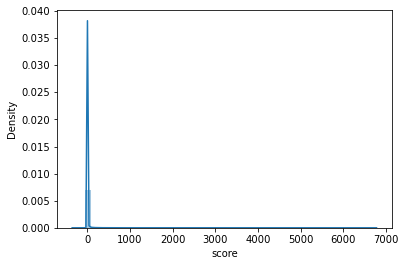

In [79]:
# Density plot of the score
sns.distplot(data['score'], kde=True)
plt.show()

Each single comment as a score. There are 4292 differents scores. 

In [80]:
# Frequency of the score
freq_score = data['score'].astype(str).value_counts(ascending = False)
freq_score.head(20)

1     2228454
2      749216
3      284206
0      199379
4       97939
5       87035
6       62145
-1      50244
7       44373
8       33836
9       26991
10      21926
-2      20488
11      18235
12      15432
13      13332
14      11361
15       9962
-3       9555
16       8971
Name: score, dtype: int64

As one can see it on the density plot and with the frequency, most of the scores seem to be rather small values (not so many are going above 20). One can also see that most of the comments' score is 1 and it seems there aren't many negative values. 

In [81]:
# Summary statistics of the score
data['score'].describe()

count    4.234970e+06
mean     1.260622e+01
std      1.245143e+02
min     -3.330000e+02
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      6.761000e+03
Name: score, dtype: float64

In average, comments have a score of around 1 and 75% of the comments have a score of around 7 or less. 

In [82]:
# See if the score and ups variables give the same information
data['score'].equals(data['ups'])

True

The score and ups columns are exactly the same, thus the score variable will be deleted. 

## 1.8. Exploration of the variable "score_hidden"

It is a boolean indicating whether the score is hidden or not.

In [83]:
# Frequency of the variable score_hidden
data.groupby('score_hidden').size()

score_hidden
0    4227959
1       7011
dtype: int64

In [84]:
# Number of missing values
data['score_hidden'].isna().sum()

0

In [85]:
# Percentage of comments with an hidden score
data['score_hidden'].astype(str).value_counts(ascending = False, normalize = True)*100

0    99.83445
1     0.16555
Name: score_hidden, dtype: float64

Most of the score are not hidden.

## 1.9. Exploration of the variable "gilded"

It is the number of time this comment received reddit gold.

In [86]:
# Frequency of the variable gilded
data.groupby('gilded').size()

gilded
0     4231979
1        2786
2         156
3          22
4          11
5           8
6           2
7           2
8           1
9           1
11          1
12          1
dtype: int64

In [87]:
# Number of missing values
data['gilded'].isna().sum()

0

In [88]:
# Percentage of comments controversed
data['gilded'].astype(str).value_counts(ascending = False, normalize = True)*100

0     99.929374
1      0.065786
2      0.003684
3      0.000519
4      0.000260
5      0.000189
7      0.000047
6      0.000047
11     0.000024
12     0.000024
9      0.000024
8      0.000024
Name: gilded, dtype: float64

Most of the comments didn't received any reddit gold at all.

## 1.10. Exploration of the variable "parent_id"

It is the ID of the thing this comment is a reply to, either the link or a comment in it. In case of a message, null if no parent is attached.

In [89]:
print("The comments from the dataset are replies of", len(np.unique(data['parent_id'])), "other messages.")

The comments from the dataset are replies of 1464558 other messages.


In [90]:
# Number of missing values
data['parent_id'].isna().sum()

0

One can see that some of the messages are linked, since 1 464 558 comments are replies from others. 

## 1.11. Exploration of the variable "link_id"

It is the ID of the link this comment is in.

In [91]:
# Number of missing values
data['link_id'].isna().sum()

0

In [92]:
# Number of the different IDs
len(np.unique(data['link_id']))

148848

There are 148848 links. 

## 1.12. Exploration of the variable "subreddit_id"

It is the id of the subreddit in which the thing is located.

In [93]:
# Frequency of the variable subreddit_id
data.groupby('subreddit_id').size()

subreddit_id
t5_2qh1i    4234970
dtype: int64

In [94]:
# Number of missing values
data['subreddit_id'].isna().sum()

0

In [95]:
# Number of different values
len(np.unique(data['subreddit_id']))

1

One can see that all the comments are located at the same subreddit. This variable can be left behind.

## 1.13. Exploration of the variable "subreddit"

It is the subreddit of thing excluded the /r/ prefix. One can expect to have the same conclusion as for the variable "subreddit_id".

In [96]:
# Frequency of the variable subreddit
data.groupby('subreddit').size()

subreddit
AskReddit    4234970
dtype: int64

In [97]:
# Number of missing values
data['subreddit'].isna().sum()

0

In [98]:
# Number of different values
len(np.unique(data['subreddit']))

1

One can see that all the comments are located at the same subreddit. This variable can be left behind.

## 1.14. Exploration of the variable "id"

It is the item identifier.

In [99]:
# Number of missing values
data['id'].isna().sum()

0

In [100]:
# Number of different values
len(np.unique(data['id']))

4234970

The id will not help the analysis as there is one unique value per comment, thus this variable is left behind

## 1.15. Exploration of the variable "created_utc"

It is the time of creation in UTC epoch-second format.

In [101]:
# Create date variable from the UTC 
dates = data.created_utc.apply(lambda x: datetime.fromtimestamp(x, timezone.utc).strftime('%Y-%m-%d %H:%M:%S'))

In [102]:
print('The most recent date is', min(dates))
print('The most ancient date is', max(dates))

The most recent date is 2015-05-01 00:00:00
The most ancient date is 2015-05-31 23:59:59


In [103]:
data['created_utc'].isna().sum()

0

In [104]:
# Number of different values
len(np.unique(data['created_utc']))

2035708

In [105]:
days = data.created_utc.apply(lambda x: datetime.fromtimestamp(x, timezone.utc).strftime('%d'))

In [106]:
days.astype(str).value_counts(ascending = False).head(5)

29    186490
28    183461
06    175429
26    160563
13    159254
Name: created_utc, dtype: int64

One can see that, as suggested in the title 'Ask Reddit May2015', the data covers all the month of May 2015. The high number of different values is because the time is also taken into account. The days were most of the comments were posted are the 29th and 28th. 

## 1.16. Exploration of the variable "name"

It is the full name of the comment.

In [107]:
# Number of missing values
data['name'].isna().sum()

0

In [108]:
# Number of different values
len(np.unique(data['name']))

4234970

The name will not help the analysis as there is one unique value per comment, thus this variable is left behind

## 1.17. Exploration of the variable "edited"

It takes false as value is the comment is not edited, and shows the edit date in UTC epoch-seconds otherwise. It can be set to true if the comment has been edited a long time ago.

In [109]:
# Number of missing val
data['edited'].isna().sum()

0

In [110]:
# Number of different values
len(np.unique(data['edited']))

79232

The number of values suggest there are many edit dates. 

## 1.18. Exploration of the variable "author_flair_css_class"

It is the CSS class of the author's flair

In [111]:
# Number of missing values
data['author_flair_css_class'].isna().sum()

4234970

This variable is filled by NaN. It can be dropped from the analysis.

## 1.19. Exploration of the variable "author_flair_text"

It is the text of the author's flair.

In [112]:
# Number of missing values
data['author_flair_text'].isna().sum()

4234970

This variable is filled by NaN. It can be dropped from the analysis.

# 2. Part 2: Data Preparation

## 2.1. Dropping some variables

Some of the variables are dropped.

* distinguished: too many missing values
* controversiality: databases project specific
* removal_reason: databases project specific
* score: identical to the ups variable
* score_hidden: not a lot of information in it
* gilded: not a lot of information in it
* downs: only one value for all the observations
* subreddit_id: only one value for all the observations
* subreddit: only one value for all the observations
* name: only one value for all the observations
* author_flair_css_class: filled by Nan
* author_flair_text: filled by NaN

id is kept for now because it will be used later, but will then be deleted. 

In [113]:
# New data with the columns kept
df = data.drop(columns=['distinguished','gilded','score_hidden', 'controversiality', 'removal_reason', 'score', 
                        'downs',  'subreddit_id', 'subreddit', 'name', 
                        'author_flair_css_class','author_flair_text'])

In [114]:
print('There are', np.shape(df)[0], 'comments and', np.shape(df)[1],'variables in the dataset.')

There are 4234970 comments and 8 variables in the dataset.


## 2.2. Dropping some observations

In [115]:
# Drop the missing values
df = df.dropna(subset=['body'])

In [116]:
print('There are', np.shape(df)[0], 'comments and', np.shape(df)[1],'variables in the dataset.')

There are 4234920 comments and 8 variables in the dataset.


## 2.3. Only keeping 20% of our database using a random split

In [117]:
small_data = df.sample(frac = 0.2, random_state = 0)
small_data = small_data.dropna(subset=['body'])
small_data.index = range(0, len(small_data))
small_data.head()

,author,ups,parent_id,link_id,id,created_utc,body,edited
0,PyjamaTime,1,t1_cr6f3hi,t3_35mafw,cr77mpp,1431476595,The fact that he's an ex means you're doing we...,0
1,Keep-reefer-illegal,1,t3_34uk38,t3_34uk38,cqyuxa1,1430807843,"Not looking while you are driving, you can kil...",0
2,mistersound,1,t3_351ltq,t3_351ltq,cr02uw4,1430908351,The ability to put 'DOTS'....on walls...DUHN D...,0
3,lfslshlps,1,t3_34wrf7,t3_34wrf7,cqytf4h,1430803026,Just because someone is visually impaired does...,0
4,Mersaul,1,t1_cr9i1hs,t3_35sz6h,cr9yxkb,1431696779,http://ajcn.nutrition.org/content/87/5/1107.fu...,0


In [118]:
print('There are', np.shape(small_data)[0], 'comments and', np.shape(small_data)[1],'variables in the reduced dataset.')

There are 846984 comments and 8 variables in the reduced dataset.


In [119]:
# Columns of our data
small_data.columns

Index(['author', 'ups', 'parent_id', 'link_id', 'id', 'created_utc', 'body',
       'edited'],
      dtype='object')

## 2.4. Cleaning of the comment

### Save a copy

In [120]:
# Copy of our data
small_data_clean=small_data.copy()

### Implementation of new features

In [121]:
# Find link
def has_link(df, colname):
    df["has_link"] = df[colname].str.contains('http')
    df["has_link"] = df['has_link'].astype(int)
    print('link')
    return df

# Find hashtag #
def has_hashtag(df, colname):
    df["has_hashtag"] = df[colname].str.contains('#')
    df["has_hashtag"] = df['has_hashtag'].astype(int)
    print('#')
    return df

# Find exclamation point !
def count_exclamation_point(df, colname):
    df['count_exclamation_point'] = df[colname].str.count('!')
    print('!')
    return df

# Find punctuation
def not_regex(pattern):
        return r"((?!><*&{}).)".format(pattern)

def count_punctuation(df, colname):
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df['count_punctuation'] = df[colname].str.count(not_regex(alphanumeric_characters_extended))
    print('punct')
    return df

#- Find ratio of unique words 
def count_unique(df, colname):
    df['num_unique_words'] = df[colname].apply(lambda comment: len(set(w for w in comment.split())))
    print('num_unique_words')
    return df

def count_words(df, colname):
    df['num_words'] = df[colname].apply(lambda comment: len(comment.split()))
    print('num_words')
    return df

def ratio_words(df, colname):
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    print('ratio unique')
    return df
    
#--- Find happy_smiley:
def happy_smiley(df, colname):
    df['num_smilies'] = df[colname].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)', ':D')))
    print(':)')
    return df
#--- Find sad_smiley:
def sad_smiley(df, colname):
    df['num_sad'] = df[colname].apply(lambda comment: sum(comment.count(w) for w in (':-<',':-(', ':(', ';-(', ';(')))
    print(':(')
    return df

#--- Final function to apply all previous functions
def feature_implementation(df, colname):

    df = (
        df
        .pipe(has_link, colname)
        .pipe(has_hashtag, colname)
        .pipe(count_exclamation_point, colname)
        .pipe(count_punctuation, colname)
        .pipe(count_words,colname)
        .pipe(count_unique, colname)
        .pipe(ratio_words, colname)
        .pipe(happy_smiley, colname)
        .pipe(sad_smiley, colname)
    ) 
    return df

In [122]:
feature_implementation(small_data_clean, 'body') 
small_data_clean.head()

link
#
!
punct
num_words
num_unique_words
ratio unique
:)
:(


,author,ups,parent_id,link_id,id,created_utc,body,edited,has_link,has_hashtag,count_exclamation_point,count_punctuation,num_words,num_unique_words,words_vs_unique,num_smilies,num_sad
0,PyjamaTime,1,t1_cr6f3hi,t3_35mafw,cr77mpp,1431476595,The fact that he's an ex means you're doing we...,0,0,0,0,52,11,11,1.000000,1,0
1,Keep-reefer-illegal,1,t3_34uk38,t3_34uk38,cqyuxa1,1430807843,"Not looking while you are driving, you can kil...",0,0,0,0,56,10,9,0.900000,0,0
2,mistersound,1,t3_351ltq,t3_351ltq,cr02uw4,1430908351,The ability to put 'DOTS'....on walls...DUHN D...,0,0,0,4,59,8,8,1.000000,0,0
3,lfslshlps,1,t3_34wrf7,t3_34wrf7,cqytf4h,1430803026,Just because someone is visually impaired does...,0,0,0,0,220,34,26,0.764706,0,0
4,Mersaul,1,t1_cr9i1hs,t3_35sz6h,cr9yxkb,1431696779,http://ajcn.nutrition.org/content/87/5/1107.fu...,0,1,0,0,483,81,62,0.765432,0,0


### Functions to clean

In [123]:
# Define the stopwords
sw = stopwords.words('english')

# Convert text to lowercase
def convert_text_to_lowercase(df, colname):
    df[colname] = df[colname].str.lower()
    print('lower')
    return df

def not_regex(pattern):
        return r"((?!{}).)".format(pattern)

# Remove punctuation and new line characters '\n'
def remove_punctuation(df, colname):
    df[colname] = df[colname].str.replace('\n', ' ')
    df[colname] = df[colname].str.replace('\r', ' ')    
    df[colname] = df[colname].str.replace('.', ' ')
    df[colname] = df[colname].str.replace(',', ' ')
    df[colname] = df[colname].str.replace('&', ' ')
    df[colname] = df[colname].str.replace('(', ' ')
    df[colname] = df[colname].str.replace(')', ' ')
    df[colname] = df[colname].str.replace('[', ' ')
    df[colname] = df[colname].str.replace(']', ' ')
    df[colname] = df[colname].str.replace('{', ' ')
    df[colname] = df[colname].str.replace('}', ' ')
    df[colname] = df[colname].str.replace('*', ' ')
    df[colname] = df[colname].str.replace('?', ' ')
    df[colname] = df[colname].str.replace('!', ' ')
    df[colname] = df[colname].str.replace(';', ' ')
    df[colname] = df[colname].str.replace('<', ' ')
    df[colname] = df[colname].str.replace('>', ' ')
    df[colname] = df[colname].str.replace('/', ' ')
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df[colname] = df[colname].str.replace(not_regex(alphanumeric_characters_extended), ' ')
    print('punct')
    return df

# Tokenize sentences
def tokenize_sentence(df, colname):
    df[colname] = df[colname].str.split()
    print('tok')
    return df

# Remove the stopwords
def remove_stop_words(df, colname):
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in sw])
    print('remove')
    return df

# Lemmatisation (get the root of words)
def lemm(df, colname):
    df[colname] = df[colname].apply(lambda x: [wnl.lemmatize(word) for word in x])
    print('lemm')
    return df

# Convert tokenized text to text
def reverse_tokenize_sentence(df, colname):
    df[colname] = df[colname].map(lambda word: ' '.join(word))
    print('reverse')
    return df

# Apply all the functions the text
def text_cleaning(df, colname):
    df = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
        .pipe(tokenize_sentence, colname)
        .pipe(remove_stop_words, colname)
        .pipe(lemm, colname)
        .pipe(reverse_tokenize_sentence, colname)
    )
    return df

In [124]:
def corpus(target):
    
    # remove urls
    target = re.sub(r'http\S+', " ", target)
    
    # remove hashtag
    target = re.sub(r'#\d+', " ", target)

    # remove mentions
    target = re.sub(r'@\S+',' ', target)

    # remove digits
    target = re.sub(r'\d+', ' ', target)

    # remove html tags
    target = re.sub('r<.*?>',' ', target)
    
    # remove co
    target = re.sub(r'co\S+', " ", target)
          
    return target

### Apply the cleaning on the body

In [125]:
text_cleaning(small_data_clean, 'body')
small_data_clean['body']

lower
punct
tok
remove
lemm
reverse


0                                         fact ex mean well
1                              looking driving kill someone
2                      ability put dot wall duhn duhn duhhh
3         someone visually impaired mean totally blind 1...
4         http ajcn nutrition org content 87 5 1107 full...
                                ...                        
846979                                                     
846980                                        groundhog day
846981    flow way always high-five guy turn lesbian tea...
846982                                   make reddit famous
846983                                                  hug
Name: body, Length: 846984, dtype: object

In [126]:
small_data_clean['body'] = small_data_clean['body'].apply(lambda x: corpus(x))

In [127]:
small_data_clean.head()

,author,ups,parent_id,link_id,id,created_utc,body,edited,has_link,has_hashtag,count_exclamation_point,count_punctuation,num_words,num_unique_words,words_vs_unique,num_smilies,num_sad
0,PyjamaTime,1,t1_cr6f3hi,t3_35mafw,cr77mpp,1431476595,fact ex mean well,0,0,0,0,52,11,11,1.000000,1,0
1,Keep-reefer-illegal,1,t3_34uk38,t3_34uk38,cqyuxa1,1430807843,looking driving kill someone,0,0,0,0,56,10,9,0.900000,0,0
2,mistersound,1,t3_351ltq,t3_351ltq,cr02uw4,1430908351,ability put dot wall duhn duhn duhhh,0,0,0,4,59,8,8,1.000000,0,0
3,lfslshlps,1,t3_34wrf7,t3_34wrf7,cqytf4h,1430803026,someone visually impaired mean totally blind ...,0,0,0,0,220,34,26,0.764706,0,0
4,Mersaul,1,t1_cr9i1hs,t3_35sz6h,cr9yxkb,1431696779,http ajcn nutrition org full think idi...,0,1,0,0,483,81,62,0.765432,0,0


## 2.5. Features gotten with the words in the cleaned comments

In [128]:
# Add number of words in the cleaned body
small_data_clean["len_body"] = small_data_clean["body"].str.split().str.len()
small_data_clean.head()

,author,ups,parent_id,link_id,id,created_utc,body,edited,has_link,has_hashtag,count_exclamation_point,count_punctuation,num_words,num_unique_words,words_vs_unique,num_smilies,num_sad,len_body
0,PyjamaTime,1,t1_cr6f3hi,t3_35mafw,cr77mpp,1431476595,fact ex mean well,0,0,0,0,52,11,11,1.000000,1,0,4
1,Keep-reefer-illegal,1,t3_34uk38,t3_34uk38,cqyuxa1,1430807843,looking driving kill someone,0,0,0,0,56,10,9,0.900000,0,0,4
2,mistersound,1,t3_351ltq,t3_351ltq,cr02uw4,1430908351,ability put dot wall duhn duhn duhhh,0,0,0,4,59,8,8,1.000000,0,0,7
3,lfslshlps,1,t3_34wrf7,t3_34wrf7,cqytf4h,1430803026,someone visually impaired mean totally blind ...,0,0,0,0,220,34,26,0.764706,0,0,17
4,Mersaul,1,t1_cr9i1hs,t3_35sz6h,cr9yxkb,1431696779,http ajcn nutrition org full think idi...,0,1,0,0,483,81,62,0.765432,0,0,41


In [129]:
# Add number of words in the cleaned body
small_data_clean["body_strip"] = small_data_clean["body"].replace(" ", "")
small_data_clean["mean_size_word"] = small_data_clean["body_strip"].str.len()/small_data_clean["len_body"]
small_data_clean = small_data_clean.drop(columns=['body_strip'])
small_data_clean.head()

,author,ups,parent_id,link_id,id,created_utc,body,edited,has_link,has_hashtag,count_exclamation_point,count_punctuation,num_words,num_unique_words,words_vs_unique,num_smilies,num_sad,len_body,mean_size_word
0,PyjamaTime,1,t1_cr6f3hi,t3_35mafw,cr77mpp,1431476595,fact ex mean well,0,0,0,0,52,11,11,1.000000,1,0,4,4.250000
1,Keep-reefer-illegal,1,t3_34uk38,t3_34uk38,cqyuxa1,1430807843,looking driving kill someone,0,0,0,0,56,10,9,0.900000,0,0,4,7.000000
2,mistersound,1,t3_351ltq,t3_351ltq,cr02uw4,1430908351,ability put dot wall duhn duhn duhhh,0,0,0,4,59,8,8,1.000000,0,0,7,5.142857
3,lfslshlps,1,t3_34wrf7,t3_34wrf7,cqytf4h,1430803026,someone visually impaired mean totally blind ...,0,0,0,0,220,34,26,0.764706,0,0,17,7.235294
4,Mersaul,1,t1_cr9i1hs,t3_35sz6h,cr9yxkb,1431696779,http ajcn nutrition org full think idi...,0,1,0,0,483,81,62,0.765432,0,0,41,6.560976


In [130]:
# Count the number of times each word appears
wordcount={}
for i in range(len(small_data_clean['body'])):
    for word in str(small_data_clean.iloc[i]['body']).split():
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1

In [131]:
# Most used words
d = dict(sorted(wordcount.items(), key=lambda item: item[1], reverse=True))
d

{'like': 105769,
 'one': 81752,
 'people': 81660,
 'get': 78689,
 'would': 73087,
 'time': 65711,
 'deleted': 57370,
 'know': 52007,
 'thing': 50276,
 'think': 49773,
 'make': 47823,
 'really': 46123,
 'go': 45352,
 'r': 43253,
 'year': 41654,
 'good': 39728,
 'day': 36947,
 'http': 36803,
 'way': 36180,
 'question': 35944,
 'even': 35220,
 'please': 34370,
 'want': 34034,
 'much': 33472,
 'something': 33005,
 'never': 32727,
 'say': 32635,
 'got': 31519,
 'see': 31128,
 'also': 30903,
 'work': 30890,
 'well': 29697,
 'still': 29088,
 'reddit': 28284,
 'life': 28178,
 'friend': 28171,
 'back': 27778,
 'need': 27433,
 'going': 27373,
 'lot': 27137,
 'feel': 27062,
 'post': 26733,
 'guy': 26651,
 'someone': 26551,
 'right': 26491,
 'u': 24864,
 'www': 24627,
 'first': 24468,
 'take': 24167,
 'shit': 23636,
 'every': 23296,
 'pretty': 22710,
 'try': 22296,
 'look': 22247,
 'always': 22162,
 'actually': 21957,
 'askreddit': 21328,
 'message': 20698,
 'said': 20488,
 'love': 20250,
 'though

In [132]:
# List of the 10 most used words
common_words = list(islice(d.keys(), 10))
common_words

['like',
 'one',
 'people',
 'get',
 'would',
 'time',
 'deleted',
 'know',
 'thing',
 'think']

In [133]:
# Ratio of the most common words used
small_data_clean['famous_words'] = small_data_clean['body'].apply(lambda word: sum(word.count(w) for w in (common_words)))
small_data_clean['ratio_famous_words'] = small_data_clean['famous_words']/small_data_clean['len_body']

In [134]:
small_data_clean.head(5)

,author,ups,parent_id,link_id,id,created_utc,body,edited,has_link,has_hashtag,...,count_punctuation,num_words,num_unique_words,words_vs_unique,num_smilies,num_sad,len_body,mean_size_word,famous_words,ratio_famous_words
0,PyjamaTime,1,t1_cr6f3hi,t3_35mafw,cr77mpp,1431476595,fact ex mean well,0,0,0,...,52,11,11,1.000000,1,0,4,4.250000,0,0.000000
1,Keep-reefer-illegal,1,t3_34uk38,t3_34uk38,cqyuxa1,1430807843,looking driving kill someone,0,0,0,...,56,10,9,0.900000,0,0,4,7.000000,1,0.250000
2,mistersound,1,t3_351ltq,t3_351ltq,cr02uw4,1430908351,ability put dot wall duhn duhn duhhh,0,0,0,...,59,8,8,1.000000,0,0,7,5.142857,0,0.000000
3,lfslshlps,1,t3_34wrf7,t3_34wrf7,cqytf4h,1430803026,someone visually impaired mean totally blind ...,0,0,0,...,220,34,26,0.764706,0,0,17,7.235294,3,0.176471
4,Mersaul,1,t1_cr9i1hs,t3_35sz6h,cr9yxkb,1431696779,http ajcn nutrition org full think idi...,0,1,0,...,483,81,62,0.765432,0,0,41,6.560976,7,0.170732


In [135]:
# Sentiment intensity analysis function
sia = SentimentIntensityAnalyzer()

In [136]:
# Negativity of the body
small_data_clean['neg_body']  = small_data_clean['body'].apply(lambda comment: 
                    list(sia.polarity_scores(comment).values())[0])

In [137]:
# Positivity of the body
small_data_clean['pos_body']  = small_data_clean['body'].apply(lambda comment: 
                    list(sia.polarity_scores(comment).values())[2])

In [138]:
small_data_clean.head(5)

,author,ups,parent_id,link_id,id,created_utc,body,edited,has_link,has_hashtag,...,num_unique_words,words_vs_unique,num_smilies,num_sad,len_body,mean_size_word,famous_words,ratio_famous_words,neg_body,pos_body
0,PyjamaTime,1,t1_cr6f3hi,t3_35mafw,cr77mpp,1431476595,fact ex mean well,0,0,0,...,11,1.000000,1,0,4,4.250000,0,0.000000,0.000,0.412
1,Keep-reefer-illegal,1,t3_34uk38,t3_34uk38,cqyuxa1,1430807843,looking driving kill someone,0,0,0,...,9,0.900000,0,0,4,7.000000,1,0.250000,0.610,0.000
2,mistersound,1,t3_351ltq,t3_351ltq,cr02uw4,1430908351,ability put dot wall duhn duhn duhhh,0,0,0,...,8,1.000000,0,0,7,5.142857,0,0.000000,0.000,0.277
3,lfslshlps,1,t3_34wrf7,t3_34wrf7,cqytf4h,1430803026,someone visually impaired mean totally blind ...,0,0,0,...,26,0.764706,0,0,17,7.235294,3,0.176471,0.384,0.060
4,Mersaul,1,t1_cr9i1hs,t3_35sz6h,cr9yxkb,1431696779,http ajcn nutrition org full think idi...,0,1,0,...,62,0.765432,0,0,41,6.560976,7,0.170732,0.344,0.042


## 2.6. Adding the degree based on the graph

### Creating the graph

In [139]:
# Create graph
graph = nx.DiGraph()

### Adding the nodes

In [140]:
# Adding nodes
graph.add_nodes_from(small_data_clean.link_id, type='link')
graph.add_nodes_from(small_data_clean.id, type='comment')

### Adding the edges

In [141]:
# Adding edges
graph.add_edges_from(small_data_clean[['id','parent_id']].values, link_type='parent')

### Computing the degrees

In [142]:
# Compute degrees
degrees = dict(nx.degree(graph, small_data_clean["parent_id"]))

In [143]:
# Create degree dataframe
degree = pd.DataFrame(degrees.items(),columns = ['parent_id','degree'])
degree

,parent_id,degree
0,t1_cr6f3hi,1
1,t3_34uk38,277
2,t3_351ltq,3
3,t3_34wrf7,1
4,t1_cr9i1hs,1
...,...,...
443958,t1_crblkxf,1
443959,t1_crefkpd,1
443960,t1_crhlvwy,1
443961,t1_cr4h11a,1


### Adding the new variable to the dataset

In [144]:
# Merge our data with degree
small_data_clean = pd.merge(small_data_clean, degree, on = 'parent_id', how = 'left')
small_data_clean.head()

,author,ups,parent_id,link_id,id,created_utc,body,edited,has_link,has_hashtag,...,words_vs_unique,num_smilies,num_sad,len_body,mean_size_word,famous_words,ratio_famous_words,neg_body,pos_body,degree
0,PyjamaTime,1,t1_cr6f3hi,t3_35mafw,cr77mpp,1431476595,fact ex mean well,0,0,0,...,1.000000,1,0,4,4.250000,0,0.000000,0.000,0.412,1
1,Keep-reefer-illegal,1,t3_34uk38,t3_34uk38,cqyuxa1,1430807843,looking driving kill someone,0,0,0,...,0.900000,0,0,4,7.000000,1,0.250000,0.610,0.000,277
2,mistersound,1,t3_351ltq,t3_351ltq,cr02uw4,1430908351,ability put dot wall duhn duhn duhhh,0,0,0,...,1.000000,0,0,7,5.142857,0,0.000000,0.000,0.277,3
3,lfslshlps,1,t3_34wrf7,t3_34wrf7,cqytf4h,1430803026,someone visually impaired mean totally blind ...,0,0,0,...,0.764706,0,0,17,7.235294,3,0.176471,0.384,0.060,1
4,Mersaul,1,t1_cr9i1hs,t3_35sz6h,cr9yxkb,1431696779,http ajcn nutrition org full think idi...,0,1,0,...,0.765432,0,0,41,6.560976,7,0.170732,0.344,0.042,1


## 2.7. Adding temporal variables

In [145]:
# Keep only the day
small_data_clean['date_day'] = small_data_clean['created_utc'].apply(lambda x: datetime.fromtimestamp(x, timezone.utc).strftime('%d'))

In [146]:
small_data_clean['date_day']

0         13
1         05
2         06
3         05
4         15
          ..
846979    22
846980    05
846981    10
846982    23
846983    03
Name: date_day, Length: 846984, dtype: object

In [147]:
# Keep only the hour
small_data_clean['time_hour'] = small_data_clean['created_utc'].apply(lambda x: datetime.fromtimestamp(x, timezone.utc).strftime('%H'))

In [148]:
small_data_clean['time_hour']

0         00
1         06
2         10
3         05
4         13
          ..
846979    17
846980    14
846981    17
846982    22
846983    20
Name: time_hour, Length: 846984, dtype: object

In [149]:
small_data_clean = small_data_clean.drop(columns=['created_utc'])

## 2.8. Number of comment by same author, parent_id or link_id

In [150]:
# Keep number of comments by author 
small_data_clean["author"] = small_data_clean["author"].map(small_data_clean["author"].value_counts())

In [151]:
# Keep number of comments by parent_id
small_data_clean["parent_id"] = small_data_clean["parent_id"].map(small_data_clean["parent_id"].value_counts())

In [152]:
# Keep number of comments by link_id
small_data_clean["link_id"] = small_data_clean["link_id"].map(small_data_clean["link_id"].value_counts())

## 2.9. Edited comments

In [153]:
# Get day and hour
small_data_clean['edited_day'] = small_data_clean['edited'].apply(lambda x: datetime.fromtimestamp(x, timezone.utc).strftime('%d'))
small_data_clean['edited_hour'] = small_data_clean['edited'].apply(lambda x: datetime.fromtimestamp(x, timezone.utc).strftime('%H'))

In [154]:
# Conditions
small_data_clean['edited_same_day'] = np.where(small_data_clean["edited_day"]==small_data_clean['date_day'], 0, 1)
small_data_clean['edited_same_hour'] = np.where((small_data_clean["edited_hour"]==small_data_clean['time_hour']) & (small_data_clean["edited_day"]==small_data_clean['date_day']), 0, 1)

In [155]:
# Drop columns
small_data_clean=small_data_clean.drop(columns=['edited_day','edited_hour'])

In [156]:
# Change to 0 if the comment was edited and 1 otherwise
small_data_clean["edited"] = np.where(small_data_clean["edited"].isin([0]), 0, 1)
small_data_clean["edited"]


0         0
1         0
2         0
3         0
4         0
         ..
846979    0
846980    0
846981    0
846982    0
846983    0
Name: edited, Length: 846984, dtype: int64

## 2.10. Final table

In [157]:
# Delete column id
small_data_clean=small_data_clean.drop(columns=['id', 'parent_id','body'])

In [158]:
# Delete missing values
small_data_clean.loc[small_data_clean['words_vs_unique'].isnull(), 'words_vs_unique'] = 0
small_data_clean.loc[small_data_clean['ratio_famous_words'].isnull(), 'ratio_famous_words'] = 0
small_data_clean.loc[small_data_clean['mean_size_word'].isnull(), 'mean_size_word'] = 0
small_data_clean.replace([np.inf, -np.inf], 0, inplace=True)

In [159]:
small_data_clean.columns

Index(['author', 'ups', 'link_id', 'edited', 'has_link', 'has_hashtag',
       'count_exclamation_point', 'count_punctuation', 'num_words',
       'num_unique_words', 'words_vs_unique', 'num_smilies', 'num_sad',
       'len_body', 'mean_size_word', 'famous_words', 'ratio_famous_words',
       'neg_body', 'pos_body', 'degree', 'date_day', 'time_hour',
       'edited_same_day', 'edited_same_hour'],
      dtype='object')

In [160]:
# Change everything to float
small_data_clean = small_data_clean.astype(float)

In [161]:
# Correlations
small_data_clean.corr()

,author,ups,link_id,edited,has_link,has_hashtag,count_exclamation_point,count_punctuation,num_words,num_unique_words,...,mean_size_word,famous_words,ratio_famous_words,neg_body,pos_body,degree,date_day,time_hour,edited_same_day,edited_same_hour
author,1.000000,-0.018750,-0.022263,0.060837,-0.032943,0.000292,-0.041670,-0.118970,-0.126336,-0.162374,...,0.012013,-0.013771,0.838986,-0.153898,-0.193510,-0.003343,-0.028996,-0.007024,-0.026938,-0.026479
ups,-0.018750,1.000000,0.039869,0.065086,0.003534,-0.003458,0.006347,0.027097,0.028209,0.029819,...,-0.000088,0.020203,-0.016118,0.009174,0.002623,0.001430,-0.002482,0.005544,-0.021914,-0.002479
link_id,-0.022263,0.039869,1.000000,0.006110,-0.042685,-0.041910,-0.003413,0.033365,0.043163,0.044844,...,0.000117,0.048345,-0.007071,-0.005824,0.024007,0.447160,0.086308,0.064283,0.014421,0.001562
edited,0.060837,0.065086,0.006110,1.000000,0.047779,0.001490,0.014265,0.147344,0.146204,0.149701,...,0.003233,0.130075,0.056936,-0.001823,-0.012343,-0.006130,-0.005405,0.003087,-0.520062,-0.643475
has_link,-0.032943,0.003534,-0.042685,0.047779,1.000000,0.396330,0.098557,0.201649,0.122829,0.130773,...,0.005169,0.012034,-0.073786,-0.048295,-0.026049,-0.021282,-0.003803,0.003488,-0.022847,-0.038901
has_hashtag,0.000292,-0.003458,-0.041910,0.001490,0.396330,1.000000,0.160080,0.231737,0.169133,0.171871,...,0.012187,-0.004026,-0.040885,-0.022861,0.006404,-0.013654,-0.006193,0.000684,-0.000622,-0.002292
count_exclamation_point,-0.041670,0.006347,-0.003413,0.014265,0.098557,0.160080,1.000000,0.160162,0.146362,0.141322,...,-0.000005,0.072835,-0.053816,0.003056,0.050894,-0.013238,-0.002722,0.002360,-0.008969,-0.010873
count_punctuation,-0.118970,0.027097,0.033365,0.147344,0.201649,0.231737,0.160162,1.000000,0.985105,0.967703,...,0.068273,0.760740,-0.103827,0.049386,0.059192,0.008959,-0.014317,0.015437,-0.088427,-0.118004
num_words,-0.126336,0.028209,0.043163,0.146204,0.122829,0.169133,0.146362,0.985105,1.000000,0.972732,...,0.008144,0.786817,-0.102552,0.056757,0.064271,0.023162,-0.014039,0.015948,-0.088741,-0.117469
num_unique_words,-0.162374,0.029819,0.044844,0.149701,0.130773,0.171871,0.141322,0.967703,0.972732,1.000000,...,0.009767,0.774708,-0.129823,0.074093,0.082410,0.001574,-0.019069,0.017016,-0.091822,-0.120278


<AxesSubplot:>

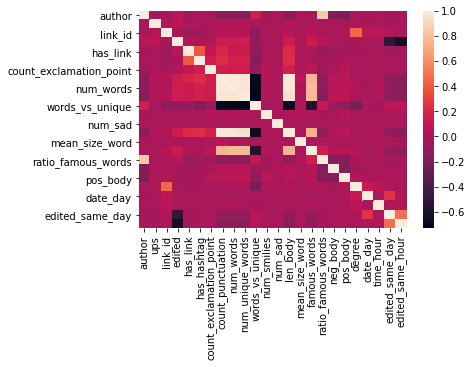

In [162]:
# Heatmap
sns.heatmap(small_data_clean.corr())

In [163]:
# Delete columns that give the same information
small_data_clean = small_data_clean.drop(columns=['count_punctuation', 'num_words', 'len_body'])

In [164]:
# Final table
small_data_clean

,author,ups,link_id,edited,has_link,has_hashtag,count_exclamation_point,num_unique_words,words_vs_unique,num_smilies,...,mean_size_word,famous_words,ratio_famous_words,neg_body,pos_body,degree,date_day,time_hour,edited_same_day,edited_same_hour
0,14.0,1.0,1560.0,0.0,0.0,0.0,0.0,11.0,1.000000,1.0,...,4.250000,0.0,0.000000,0.000,0.412,1.0,13.0,0.0,1.0,1.0
1,36.0,1.0,1968.0,0.0,0.0,0.0,0.0,9.0,0.900000,0.0,...,7.000000,1.0,0.250000,0.610,0.000,277.0,5.0,6.0,1.0,1.0
2,2.0,1.0,7.0,0.0,0.0,0.0,4.0,8.0,1.000000,0.0,...,5.142857,0.0,0.000000,0.000,0.277,3.0,6.0,10.0,1.0,1.0
3,16.0,1.0,1.0,0.0,0.0,0.0,0.0,26.0,0.764706,0.0,...,7.235294,3.0,0.176471,0.384,0.060,1.0,5.0,5.0,1.0,1.0
4,5.0,1.0,3285.0,0.0,1.0,0.0,0.0,62.0,0.765432,0.0,...,6.560976,7.0,0.170732,0.344,0.042,1.0,15.0,13.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846979,13.0,1.0,33.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.0,...,0.000000,0.0,0.000000,0.000,0.000,1.0,22.0,17.0,1.0,1.0
846980,35.0,3.0,20.0,0.0,0.0,0.0,0.0,2.0,1.000000,0.0,...,6.500000,0.0,0.000000,0.000,0.000,13.0,5.0,14.0,1.0,1.0
846981,49.0,2.0,1257.0,0.0,0.0,0.0,0.0,26.0,0.896552,0.0,...,6.769231,0.0,0.000000,0.000,0.000,1.0,10.0,17.0,1.0,1.0
846982,1.0,1.0,399.0,0.0,0.0,0.0,0.0,6.0,1.000000,0.0,...,6.000000,0.0,0.000000,0.000,0.000,1.0,23.0,22.0,1.0,1.0


<AxesSubplot:>

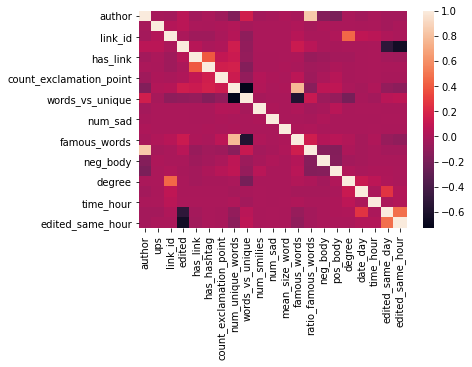

In [165]:
# Heatmap
sns.heatmap(small_data_clean.corr())

## 2.11. Summary statistics

In [166]:
# 1.author
small_data_clean.author.describe()

count    846984.000000
mean       4708.953144
std       16338.856163
min           1.000000
25%           2.000000
50%           7.000000
75%          31.000000
max       62528.000000
Name: author, dtype: float64

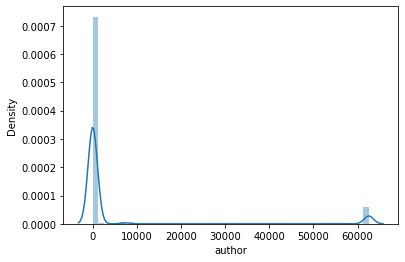

In [167]:
sns.distplot(small_data_clean.author, kde=True)
plt.show()

In [168]:
# 2.ups
small_data_clean.ups.describe()

count    846984.000000
mean         12.552725
std         123.216666
min        -149.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        5927.000000
Name: ups, dtype: float64

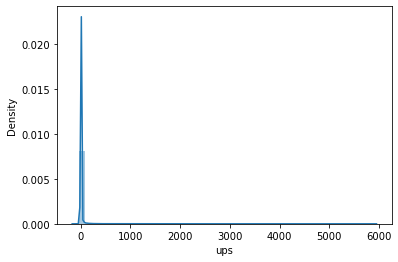

In [169]:
sns.distplot(small_data_clean.ups, kde=True)
plt.show()

In [170]:
# 3.link_id
small_data_clean.link_id.describe()

count    846984.000000
mean        985.336429
std        1459.012041
min           1.000000
25%           9.000000
50%         299.000000
75%        1394.000000
max        7207.000000
Name: link_id, dtype: float64

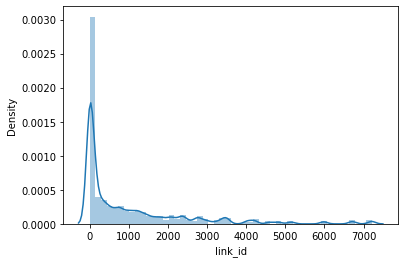

In [171]:
sns.distplot(small_data_clean.link_id, kde=True)
plt.show()

In [172]:
# 4.edited
small_data_clean.groupby('edited').size()

edited
0.0    830882
1.0     16102
dtype: int64

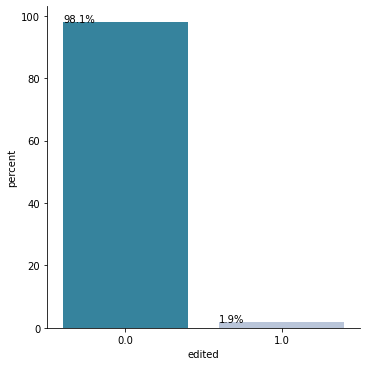

In [173]:
# We draw the barplot of the variable edited
freq_edited = small_data_clean["edited"].astype(str).value_counts(normalize=True)*100
l = []

# Creation of a dictionnary with the modalities and the frequency linked to the modalities
for i in range (freq_edited.shape[0]):
    l.append({"edited":freq_edited.index[i], "percent":freq_edited[i]})

# We transform this dictionnary into a dataframe
df_esh = pd.DataFrame(l)

# We plot the barplot (without the frequencies)
g = sns.catplot(x = "edited", y = "percent", kind= 'bar',data = df_esh, palette = 'PuBuGn_r')

# We add the frequencies at the top of each bar
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [174]:
# 5.has_link
small_data_clean.groupby('has_link').size()

has_link
0.0    819327
1.0     27657
dtype: int64

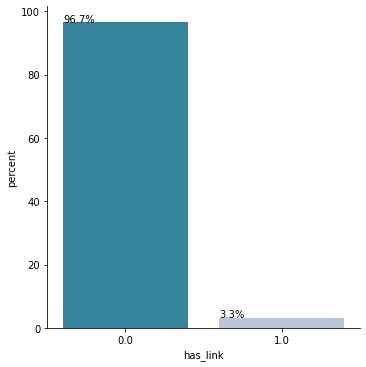

In [175]:
# We draw the barplot of the variable has_link
freq_hl= small_data_clean["has_link"].astype(str).value_counts(normalize=True)*100
l = []

# Creation of a dictionnary with the modalities and the frequency linked to the modalities
for i in range (freq_hl.shape[0]):
    l.append({"has_link":freq_hl.index[i], "percent":freq_hl[i]})

# We transform this dictionnary into a dataframe
df_hl = pd.DataFrame(l)

# We plot the barplot (without the frequencies)
g = sns.catplot(x = "has_link", y = "percent", kind= 'bar',data = df_hl, palette = 'PuBuGn_r')

# We add the frequencies at the top of each bar
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [176]:
# 6.has_hashtag
small_data_clean.groupby('has_hashtag').size()

has_hashtag
0.0    839819
1.0      7165
dtype: int64

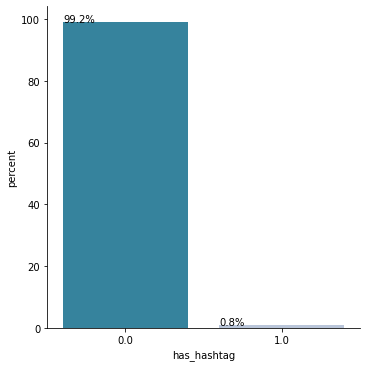

In [177]:
# We draw the barplot of the variable has_hashtag
freq_hh= small_data_clean["has_hashtag"].astype(str).value_counts(normalize=True)*100
l = []

# Creation of a dictionnary with the modalities and the frequency linked to the modalities
for i in range (freq_hh.shape[0]):
    l.append({"has_hashtag":freq_hh.index[i], "percent":freq_hh[i]})

# We transform this dictionnary into a dataframe
df_hh = pd.DataFrame(l)

# We plot the barplot (without the frequencies)
g = sns.catplot(x = "has_hashtag", y = "percent", kind= 'bar',data = df_hh, palette = 'PuBuGn_r')

# We add the frequencies at the top of each bar
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [178]:
# 7.count_exclamation_point
small_data_clean.count_exclamation_point.describe()

count    846984.000000
mean          0.126401
std           0.649509
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         153.000000
Name: count_exclamation_point, dtype: float64

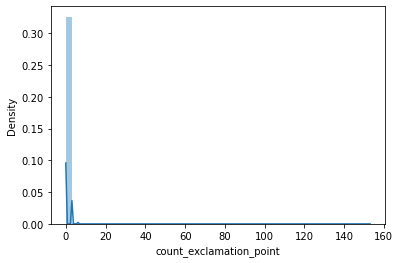

In [179]:
sns.distplot(small_data_clean.count_exclamation_point, kde=True)
plt.show()

In [180]:
# 8.num_unique_words
small_data_clean.num_unique_words.describe()

count    846984.000000
mean         20.846652
std          29.416486
min           0.000000
25%           4.000000
50%          11.000000
75%          26.000000
max         905.000000
Name: num_unique_words, dtype: float64

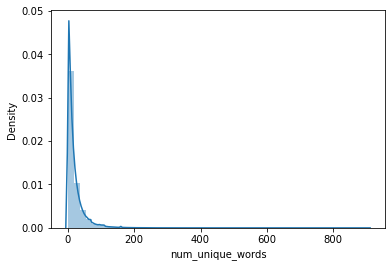

In [181]:
sns.distplot(small_data_clean.num_unique_words, kde=True)
plt.show()

In [182]:
# 9.words_vs_unique
small_data_clean.words_vs_unique.describe()

count    846984.000000
mean          0.936118
std           0.098155
min           0.000000
25%           0.892857
50%           1.000000
75%           1.000000
max           1.000000
Name: words_vs_unique, dtype: float64

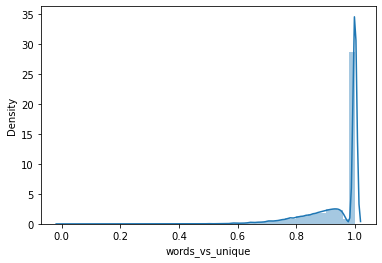

In [183]:
sns.distplot(small_data_clean.words_vs_unique, kde=True)
plt.show()

In [184]:
# 10.num_smilies
small_data_clean.num_smilies.describe()

count    846984.000000
mean          0.011105
std           0.120270
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          47.000000
Name: num_smilies, dtype: float64

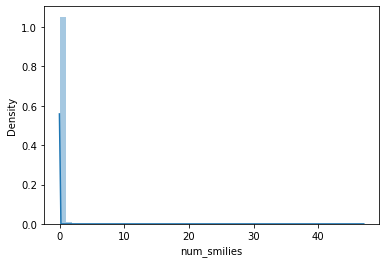

In [185]:
sns.distplot(small_data_clean.num_smilies, kde=True)
plt.show()

In [186]:
# 11.num_sad
small_data_clean.num_sad.describe()

count    846984.000000
mean          0.004822
std           0.091469
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          54.000000
Name: num_sad, dtype: float64

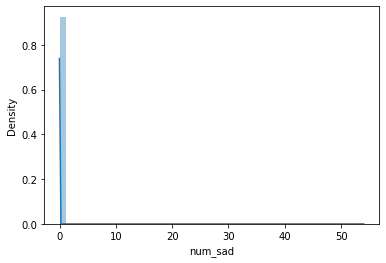

In [187]:
sns.distplot(small_data_clean.num_sad, kde=True)
plt.show()

In [188]:
# 12.mean_size_word
small_data_clean.mean_size_word.describe()

count    846984.000000
mean          6.297819
std          15.208039
min           0.000000
25%           5.666667
50%           6.363636
75%           7.000000
max        9999.000000
Name: mean_size_word, dtype: float64

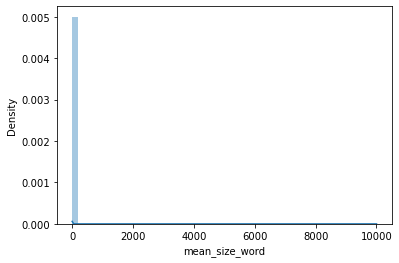

In [189]:
sns.distplot(small_data_clean.mean_size_word, kde=True)
plt.show()

In [190]:
# 13.famous_words
small_data_clean.famous_words.describe()

count    846984.000000
mean          1.137434
std           2.201941
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         300.000000
Name: famous_words, dtype: float64

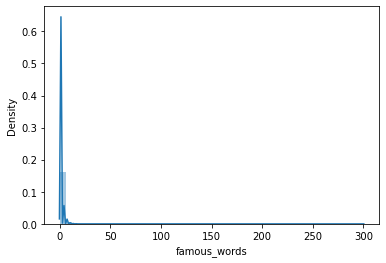

In [191]:
sns.distplot(small_data_clean.famous_words, kde=True)
plt.show()

In [192]:
# 14.ratio_famous_words
small_data_clean.ratio_famous_words.describe()

count    846984.000000
mean          0.139645
std           0.261828
min           0.000000
25%           0.000000
50%           0.000000
75%           0.150000
max          27.000000
Name: ratio_famous_words, dtype: float64

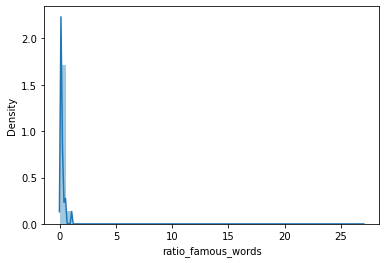

In [193]:
sns.distplot(small_data_clean.ratio_famous_words, kde=True)
plt.show()

In [194]:
# 15.neg_body
small_data_clean.neg_body.describe()

count    846984.000000
mean          0.118999
std           0.197311
min           0.000000
25%           0.000000
50%           0.000000
75%           0.193000
max           1.000000
Name: neg_body, dtype: float64

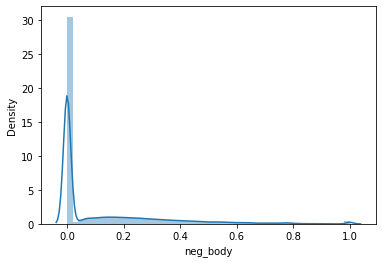

In [195]:
sns.distplot(small_data_clean.neg_body, kde=True)
plt.show()

In [196]:
# 16.pos_body
small_data_clean.pos_body.describe()

count    846984.000000
mean          0.172969
std           0.226516
min           0.000000
25%           0.000000
50%           0.045000
75%           0.296000
max           1.000000
Name: pos_body, dtype: float64

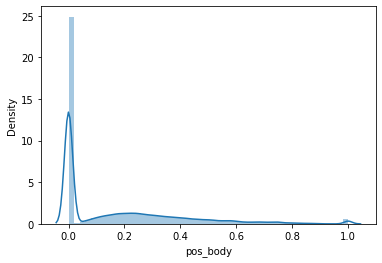

In [197]:
sns.distplot(small_data_clean.pos_body, kde=True)
plt.show()

In [198]:
# 17.degree
small_data_clean.degree.describe()

count    846984.000000
mean        111.748236
std         572.059336
min           1.000000
25%           1.000000
50%           2.000000
75%          11.000000
max        6176.000000
Name: degree, dtype: float64

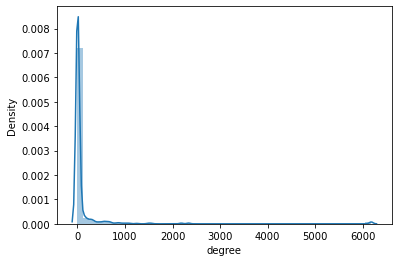

In [199]:
sns.distplot(small_data_clean.degree, kde=True)
plt.show()

In [200]:
# 18.date_day
small_data_clean.groupby('date_day').size()

date_day
1.0     28284
2.0     21847
3.0     20790
4.0     25606
5.0     29778
6.0     35162
7.0     30682
8.0     27636
9.0     22896
10.0    19297
11.0    26680
12.0    28435
13.0    32071
14.0    29339
15.0    27360
16.0    22965
17.0    27926
18.0    26346
19.0    27501
20.0    29847
21.0    30145
22.0    31245
23.0    20177
24.0    21628
25.0    23056
26.0    32069
27.0    27658
28.0    36756
29.0    37549
30.0    20444
31.0    25809
dtype: int64

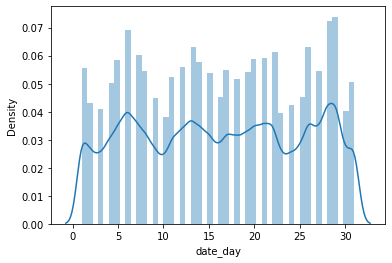

In [201]:
sns.distplot(small_data_clean.date_day, kde=True)
plt.show()

In [202]:
# 19.time_hour
small_data_clean.groupby('time_hour').size()

time_hour
0.0     39949
1.0     41813
2.0     42471
3.0     40162
4.0     36792
5.0     30284
6.0     28171
7.0     23754
8.0     19678
9.0     17506
10.0    18116
11.0    21110
12.0    26326
13.0    33784
14.0    41596
15.0    44100
16.0    43019
17.0    44907
18.0    44080
19.0    44412
20.0    43819
21.0    41896
22.0    40011
23.0    39228
dtype: int64

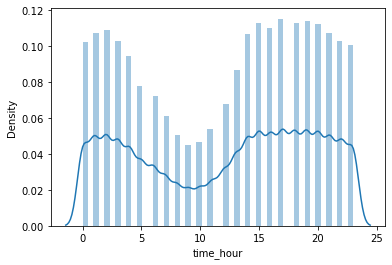

In [203]:
sns.distplot(small_data_clean.time_hour, kde=True)
plt.show()

In [204]:
# 20.edited_same_hour
small_data_clean.groupby('edited_same_hour').size()

edited_same_hour
0.0      9703
1.0    837281
dtype: int64

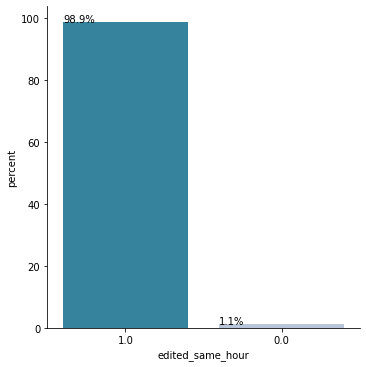

In [205]:
# We draw the barplot of the variable edited_same_hour
freq_esh = small_data_clean["edited_same_hour"].astype(str).value_counts(normalize=True)*100
l = []

# Creation of a dictionnary with the modalities and the frequency linked to the modalities
for i in range (freq_esh.shape[0]):
    l.append({"edited_same_hour":freq_esh.index[i], "percent":freq_esh[i]})

# We transform this dictionnary into a dataframe
df_esh = pd.DataFrame(l)

# We plot the barplot (without the frequencies)
g = sns.catplot(x = "edited_same_hour", y = "percent", kind= 'bar',data = df_esh, palette = 'PuBuGn_r')

# We add the frequencies at the top of each bar
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [206]:
# 20.edited_same_day
small_data_clean.groupby('edited_same_day').size()

edited_same_day
0.0     41560
1.0    805424
dtype: int64

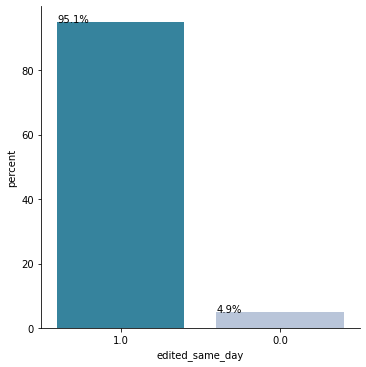

In [207]:
# We draw the barplot of the variable edited_same_day
freq_esd = small_data_clean["edited_same_day"].astype(str).value_counts(normalize=True)*100
l = []

# Creation of a dictionnary with the modalities and the frequency linked to the modalities
for i in range (freq_esd.shape[0]):
    l.append({"edited_same_day":freq_esd.index[i], "percent":freq_esd[i]})

# We transform this dictionnary into a dataframe
df_esh = pd.DataFrame(l)

# We plot the barplot (without the frequencies)
g = sns.catplot(x = "edited_same_day", y = "percent", kind= 'bar',data = df_esh, palette = 'PuBuGn_r')

# We add the frequencies at the top of each bar
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

# 3. Part 3: Predicting Ups

In [208]:
# Create train and test set
train, test = train_test_split(small_data_clean, test_size=0.3, random_state=42)

In [209]:
# Split the datasets
X_train = train.drop(columns=['ups'])
Y_train = train['ups']
X_test = test.drop(columns=['ups'])
Y_test = test['ups']


In [210]:
print('It remains', np.shape(X_train)[1], 'features.')

It remains 20 features.


## 3.1 Linear regression 

In [211]:
# Linear regression model
lr = LinearRegression()

# Fit the model on the train dataset
lr.fit(X_train,Y_train)

# Predict on the test dataset
pred_lr = lr.predict(X_test)

print("The MAE on the training sample is : {}.".format(mean_absolute_error(lr.predict(X_train), Y_train)))
print("The MAE on the test sample is : {}.".format(mean_absolute_error(pred_lr, Y_test)))

The MAE on the training sample is : 20.418423786032108.
The MAE on the test sample is : 20.79230571972969.


## 3.2 Ridge

In [212]:
# Ridge model
rd = Ridge()

# Fit the model on the train dataset
rd.fit(X_train,Y_train)

# Predict on the test dataset
pred_rd = rd.predict(X_test)

print("The MAE on the training sample is : {}.".format(mean_absolute_error(rd.predict(X_train), Y_train)))
print("The MAE on the test sample is : {}.".format(mean_absolute_error(pred_rd, Y_test)))

The MAE on the training sample is : 20.418285990462.
The MAE on the test sample is : 20.79216787338301.


## 3.3 Bayesian ridge

In [213]:
# Bayesian ridge model
br = BayesianRidge()

# Fit the model on the train dataset
br.fit(X_train,Y_train)

# Predict on the test dataset
pred_br = br.predict(X_test)

print("The MAE on the training sample is : {}.".format(mean_absolute_error(br.predict(X_train), Y_train)))
print("The MAE on the test sample is : {}.".format(mean_absolute_error(pred_br, Y_test)))

The MAE on the training sample is : 20.415721295697807.
The MAE on the test sample is : 20.789600512993655.


## 3.4 Lasso

In [214]:
# Lasso model
ls = Lasso()

# Fit the model on the train dataset
ls.fit(X_train,Y_train)

# Predict on the test dataset
pred_ls = ls.predict(X_test)

print("The MAE on the training sample is : {}.".format(mean_absolute_error(ls.predict(X_train), Y_train)))
print("The MAE on the test sample is : {}.".format(mean_absolute_error(pred_ls, Y_test)))

The MAE on the training sample is : 20.13853802356901.
The MAE on the test sample is : 20.50543831823742.


## 3.5 Decision tree

In [215]:
# Regressor decision tree model
tree = DecisionTreeRegressor(random_state=0)

# Fit the model on the train dataset
tree.fit(X_train, Y_train)

# Predict on the test dataset
pred_tree = tree.predict(X_test)

print("The MAE on the training sample is : {}.".format(mean_absolute_error(tree.predict(X_train), Y_train)))
print("The MAE on the test sample is : {}.".format(mean_absolute_error(pred_tree, Y_test)))

The MAE on the training sample is : 0.10606439860535077.
The MAE on the test sample is : 24.485596155216445.


## 3.6 Random Forest

In [216]:
# Random forest model
rf = RandomForestRegressor(max_depth=2, random_state=0)

# Fit the model on the train dataset
rf.fit(X_train,Y_train)

# Predict on the test dataset
pred_rf = rf.predict(X_test)

print("The MAE on the training sample is : {}.".format(mean_absolute_error(rf.predict(X_train), Y_train)))
print("The MAE on the test sample is : {}.".format(mean_absolute_error(pred_rf, Y_test)))

The MAE on the training sample is : 19.893025683689373.
The MAE on the test sample is : 20.257189057585475.


## 3.7 Gradient Boosting Regressor

In [217]:
# Gradient boosting model
gb = GradientBoostingRegressor(random_state=0)

# Fit the model on the train dataset
gb.fit(X_train,Y_train)

# Predict on the test dataset
pred_gb = gb.predict(X_test)

print("The MAE on the training sample is : {}.".format(mean_absolute_error(gb.predict(X_train), Y_train)))
print("The MAE on the test sample is : {}.".format(mean_absolute_error(pred_gb, Y_test)))

The MAE on the training sample is : 20.03813683079052.
The MAE on the test sample is : 20.444641144745464.


## 3.8 XGBoost

In [218]:
# XGBoost model 
XGB = XGBRegressor(random_state=0)

# Fit the model on the train dataset
XGB.fit(X_train,Y_train)

# Predict on the test dataset
pred_XGB = XGB.predict(X_test)

print("The MAE on the training sample is : {}.".format(mean_absolute_error(XGB.predict(X_train), Y_train)))
print("The MAE on the test sample is : {}.".format(mean_absolute_error(pred_XGB, Y_test)))

The MAE on the training sample is : 18.943694075836166.
The MAE on the test sample is : 20.94745828047933.


# 4. Part 4: Focus on the three best models: overfitting and hyperparameters

## 4.1.  Random Forest

In [219]:
from sklearn.model_selection import GridSearchCV

In [220]:
param_grid_rf = {
    'max_depth': [1,5,10,15,20]}

grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf, cv = 2)

grid_search_rf.fit(X_train, Y_train)
print(grid_search_rf.best_params_)

# Predict on the test dataset
pred_rf = grid_search_rf.predict(X_test)

print("The MAE on the training sample is : {}.".format(mean_absolute_error(grid_search_rf.predict(X_train), Y_train)))
print("The MAE on the test sample is : {}.".format(mean_absolute_error(pred_rf, Y_test)))

{'max_depth': 5}
The MAE on the training sample is : 19.473061012582598.
The MAE on the test sample is : 19.818040308007884.


## 4.2. XGBoost

In [221]:
param_grid_xgb = {
    'max_depth': [1,5,10,15,20]}   

grid_search_xgb = GridSearchCV(estimator = XGB, param_grid = param_grid_xgb, cv = 2)

grid_search_xgb.fit(X_train, Y_train)
print(grid_search_xgb.best_params_)

# Predict on the test dataset
pred_xgb = grid_search_xgb.predict(X_test)

print("The MAE on the training sample is : {}.".format(mean_absolute_error(grid_search_xgb.predict(X_train), Y_train)))
print("The MAE on the test sample is : {}.".format(mean_absolute_error(pred_xgb, Y_test)))

{'max_depth': 5}
The MAE on the training sample is : 19.632598188879758.
The MAE on the test sample is : 20.81969246213662.
